# DA3-A3 
## Parker & Co. -1
Peter Szilvasi,
Máté Schieszler 

In [2]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
import warnings

warnings.filterwarnings("ignore")

In [3]:
from py_helper_functions import *

In [4]:
# Read in the data offline
original_data = pd.read_csv('cs_bisnode_panel.csv')

In [5]:
# Read in the data online
#original_data = pd.read_csv('https://raw.githubusercontent.com/mateschieszler/DA3-A3/main/cs_bisnode_panel.csv')

In [6]:
# copy original so we don't have to reload it every time (it takes more than 10s)
data = original_data.copy()

In [7]:
# filter out ind2 != 26
# data = data.loc[data['ind2'] == 26] # i would comment this out 
# data['sales'].fillna(0, inplace=True)
data.shape

(287829, 48)

In [8]:
# add all missing year and comp_id combinations -
# originally missing combinations will have NAs in all other columns
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)  # only way I could define it as NaN

In [9]:
# generate status_alive; if sales larger than zero and not-NA, then firm is alive
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)

# defaults in one year if there are sales in this year but no sales the next year
# Status_in_a_year: data.groupby('comp_id')['status_alive'].shift(-1)
data["default"] = (
    (data["status_alive"] == 1)
    & (data.groupby("comp_id")["status_alive"].shift(-1) == 0)
).astype(int)

In [10]:
data.loc[data['year'] == 2014].groupby(["status_alive","default"])['comp_id'].count()

status_alive  default
0             0          24060
1             0          19885
              1           2467
Name: comp_id, dtype: int64

In [11]:
# filter for status alive = 1
data = data.loc[data["status_alive"] == 1]

In [12]:
data["default"].describe()

count    238491.000000
mean          0.154182
std           0.361124
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: default, dtype: float64

In [13]:
holdout_set = data.loc[(data['ind2'] == 26) & (data['year'] == 2014) & (data['sales'] >= 1000) & (data['sales'] <= 10000000)]

# Display information about the resulting holdout set
print("Total firms in holdout set:", len(holdout_set))
print("Number of defaulted firms:", len(holdout_set[holdout_set['default'] == 1]))
print("Number of firms that stayed alive:", len(holdout_set[holdout_set['default'] == 0]))  # Since all firms meet the condition
print("Average sales of the firms:", holdout_set['sales'].mean())
print("Minimum sales:", holdout_set['sales'].min())
print("Maximum sales:", holdout_set['sales'].max())

Total firms in holdout set: 1037
Number of defaulted firms: 56
Number of firms that stayed alive: 981
Average sales of the firms: 490202.21792682
Minimum sales: 1070.370361328125
Maximum sales: 9576485.0


In [14]:
data.shape

(238491, 50)

In [15]:
# with this -> data = working set
# data = data.drop(holdout_set.index)

## Handling Missing Values

In [16]:
# drop year 2015 and 2016
data = data.loc[data['year'] <= 2014]

In [17]:
# look at missing values
data.isna().sum()

year                         0
comp_id                      0
begin                        0
end                          0
COGS                    191311
amort                      433
curr_assets                 80
curr_liab                   80
extra_exp                 1072
extra_inc                 1072
extra_profit_loss           10
finished_prod           192185
fixed_assets                80
inc_bef_tax                  0
intang_assets               89
inventories                 80
liq_assets                  80
material_exp               433
net_dom_sales           191311
net_exp_sales           191311
personnel_exp              433
profit_loss_year            80
sales                        0
share_eq                    80
subscribed_cap              80
tang_assets               1151
wages                   191550
D                       206922
balsheet_flag                0
balsheet_length              0
balsheet_notfullyear         0
founded_year             42396
exit_yea

In [18]:
# Calculate percentage of missing values in each column of the original dataset
original_missing_percentage = (original_data.isnull().sum() / len(original_data)) * 100

# Calculate percentage of missing values in each column of the filtered dataset
filtered_missing_percentage = (data.isnull().sum() / len(data)) * 100

# Calculate percentage of missing values in each column of the filtered dataset
filtered_missing_percentage = (data.isnull().sum() / len(data)) * 100

# Combine the missing percentage information into a DataFrame for easier comparison
missing_info = pd.DataFrame({
    'Original Data Missing %': original_missing_percentage,
    'Filtered Data Missing %': filtered_missing_percentage
})

missing_info.sort_values(by='Filtered Data Missing %', ascending=False)

,Original Data Missing %,Filtered Data Missing %
D,100.000000,100.000000
finished_prod,93.925213,92.877993
wages,93.752193,92.571114
COGS,93.656998,92.455611
net_exp_sales,93.656998,92.455611
net_dom_sales,93.656998,92.455611
exit_year,86.499276,86.066247
exit_date,80.481466,80.203652
labor_avg,50.909394,48.395047
birth_year,38.848761,39.943070


Would it makes sense to examine all original data as it might have some additinal info which might uncover relations that are not present in our data?

In [19]:
# drop columns with over 12000 missing values
to_drop = ['D','exit_year','wages','finished_prod','COGS','net_exp_sales','net_dom_sales','exit_date']
data = data.drop(to_drop, axis=1)

In [20]:
# drop where industry is empty, itt nem tudom ezt kell e, vagy csak flageljük
# data = data.dropna(subset="ind2")

In [21]:
data

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,labor_avg,status_alive,default
0,2005,1.001034e+06,2005-01-01,2005-12-31,692.592590,7.266667e+03,7.574074e+03,0.000000,0.000000,0.000000,...,Domestic,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,1,0
3,2005,1.003200e+06,2005-01-01,2005-12-31,25.925926,7.296296e+02,3.803704e+03,0.000000,4814.814941,4814.814941,...,NaN,5630.0,56.0,3.0,1.0,Central,2003-10-21,NaN,1,0
4,2005,1.004012e+06,2005-01-01,2005-12-31,114.814812,1.648148e+03,3.777778e+03,0.000000,0.000000,0.000000,...,Domestic,3314.0,33.0,2.0,3.0,West,1991-11-24,NaN,1,0
7,2005,1.011889e+06,2005-01-01,2005-12-31,51625.925781,3.500370e+04,4.988889e+03,0.000000,31925.925781,31925.925781,...,Domestic,5510.0,55.0,3.0,2.0,West,1992-11-09,NaN,1,0
8,2005,1.014183e+06,2005-01-01,2005-12-31,12692.592773,7.918889e+04,2.777778e+03,0.000000,1481.481445,1481.481445,...,Domestic,5510.0,55.0,3.0,2.0,Central,2001-12-21,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464110,2014,4.639265e+11,2014-06-05,2014-12-31,407.407410,3.383704e+04,2.767407e+04,0.000000,0.000000,0.000000,...,Domestic,5610.0,56.0,3.0,3.0,West,2014-06-04,0.166667,1,1
464112,2014,4.639820e+11,2014-01-01,2014-12-31,7551.852051,8.765185e+04,1.156741e+05,0.000000,0.000000,0.000000,...,Domestic,2822.0,28.0,2.0,1.0,Central,1995-05-14,0.597222,1,0
464114,2014,4.640212e+11,2014-01-01,2014-12-31,5666.666504,1.528519e+04,1.488889e+03,0.000000,0.000000,0.000000,...,Domestic,2822.0,28.0,2.0,2.0,Central,2006-05-09,0.101852,1,0
464115,2014,4.640446e+11,2014-01-01,2014-12-31,71570.367188,6.486366e+06,2.499133e+06,0.000000,0.000000,0.000000,...,Foreign,3312.0,33.0,2.0,3.0,Central,2008-10-09,2.305556,1,0


# Label Engineering

In [22]:
data["default"].describe()

count    206922.000000
mean          0.117010
std           0.321433
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: default, dtype: float64

In [23]:
data["sales"].describe()

count    2.069220e+05
mean     5.712713e+05
std      4.188716e+06
min      1.851852e-01
25%      1.413056e+04
50%      4.370000e+04
75%      1.383315e+05
max      1.110294e+08
Name: sales, dtype: float64

In [24]:
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)  # Replaces negative values in the "sales" column with 1
data = data.assign( # Assigns new columns to the data
    ln_sales=np.where( # Natural logarithm of sales if sales is larger than 0
        data["sales"] > 0, 
        np.log(data["sales"]), 
        (np.where(data["sales"].isna(), np.nan, 0))),  # NaN remain NaN
    sales_mil=data["sales"] / 1000000, # Sales in millions
    sales_mil_log=np.where( # Natural logarithm of sales in millions if sales is larger than 0
        data["sales"] > 0, 
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)), # NaN remain NaN
    ),
)

In [25]:
data[["sales", "ln_sales", "sales_mil", "sales_mil_log"]].isna().sum()

sales            0
ln_sales         0
sales_mil        0
sales_mil_log    0
dtype: int64

In [26]:
data["sales"].describe()

count    2.069220e+05
mean     5.712713e+05
std      4.188716e+06
min      1.851852e-01
25%      1.413056e+04
50%      4.370000e+04
75%      1.383315e+05
max      1.110294e+08
Name: sales, dtype: float64

In [27]:
# This difference indicates how the logarithm of sales in millions changes from one period to the next for each company.
# It's often used to capture the rate of change or momentum in a time series.
data["d1_sales_mil_log"] = data["sales_mil_log"] - data.groupby("comp_id")[
    "sales_mil_log"
].shift(1)

In [28]:
# replace w 0 for new firms + add dummy to capture it

# add age of firm
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"])

# add dummy for new firms
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)))

# replace d1_sales_mil_log with 0 for new firms
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["d1_sales_mil_log"]))

# replace new with 0 for firms with missing d1_sales_mil_log
data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])

# replace d1_sales_mil_log with 0 for firms with missing d1_sales_mil_log
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"])

# Feature Engineering

In [29]:
#######################
### Decide here for cross section or panel
#######################
# look at cross section
#data=data.query('year==2014 & status_alive == 1')
# look at firms below 10m euro revenues and above 1000 euros
data=data.query('sales_mil<=10 & sales_mil>=0.001')

In [30]:
data.shape

(197242, 48)

In [31]:
data['default'].describe()

count    197242.000000
mean          0.107523
std           0.309777
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: default, dtype: float64

In [32]:
data.isna().sum()

year                        0
comp_id                     0
begin                       0
end                         0
amort                     334
curr_assets                70
curr_liab                  70
extra_exp                1023
extra_inc                1023
extra_profit_loss           8
fixed_assets               70
inc_bef_tax                 0
intang_assets              77
inventories                70
liq_assets                 70
material_exp              334
personnel_exp             334
profit_loss_year           70
sales                       0
share_eq                   70
subscribed_cap             70
tang_assets              1092
balsheet_flag               0
balsheet_length             0
balsheet_notfullyear        0
founded_year            40100
ceo_count               40077
foreign                 40077
female                  40077
birth_year              77210
inoffice_days           40077
gender                  40077
origin                  40077
nace_main 

In [33]:
data['ind2_cat']=data['ind2'].copy() # lets create this but skip the recategorization for now
data['ind2_cat']=np.where(data['ind2']>56,60,data['ind2_cat'])
data['ind2_cat']=np.where(data['ind2']<26,20,data['ind2_cat'])
data['ind2_cat']=np.where((data['ind2']<55)&(data['ind2']>35),40,data['ind2_cat'])
data['ind2_cat']=np.where(data['ind2']==31,30,data['ind2_cat'])
data['ind2_cat']=np.where(data['ind2'].isna(),99,data['ind2_cat'])

In [34]:
data.groupby('ind2_cat').count()['comp_id']

ind2_cat
20.0       485
26.0     10726
27.0      6492
28.0     19333
29.0      2762
30.0      1628
32.0      1481
33.0     16451
35.0         1
40.0      1951
55.0     20398
56.0    112588
60.0      2302
99.0       644
Name: comp_id, dtype: int64

In [35]:
# Firm characteristics
data["age2"] = data["age"] ** 2
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")

In [36]:
###########################################################
# look at more financial variables, create ratios
###########################################################

# assets can't be negative. Change them to 0 and add a flag.
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.0    197046
1.0       119
Name: comp_id, dtype: int64

In [37]:
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])

In [38]:
# generate total assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()

count    1.971650e+05
mean     4.128472e+05
std      3.049237e+07
min      0.000000e+00
25%      7.818519e+03
50%      2.645185e+04
75%      1.013815e+05
max      1.032471e+10
Name: total_assets_bs, dtype: float64

In [39]:
pl_names = [
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "inc_bef_tax",
    "inventories",
    "material_exp",
    "profit_loss_year",
    "personnel_exp",
]
bs_names = [
    "intang_assets",
    "curr_liab",
    "fixed_assets",
    "liq_assets",
    "curr_assets",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
]

In [40]:
# divide all pl_names elements by sales and create new column for it
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)

In [41]:
# divide all bs_names elements by total_assets_bs and create new column for it
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )

In [42]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)

In [43]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)

In [44]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)
# ok

In [45]:
########################################################################
# additional
# including some imputation
########################################################################

# CEO age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)


data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)

In [46]:
# number emp, very noisy measure
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"]
)
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)

In [47]:
data['labor_avg'].describe()

count    103808.000000
mean          0.666636
std           1.767426
min           0.083333
25%           0.104167
50%           0.243056
75%           0.552083
max          82.866669
Name: labor_avg, dtype: float64

In [48]:
data['labor_avg_mod'].describe()

count    197242.000000
mean          0.666636
std           1.282201
min           0.083333
25%           0.222222
50%           0.666636
75%           0.666636
max          82.866669
Name: labor_avg_mod, dtype: float64

In [49]:
data = data.drop(["labor_avg"], axis=1) # ez Gáboréban benne van, de nem tudom miért, hagyjuk bent

In [50]:
# create category type variables
data["urban_m"] = data["urban_m"].astype("category")
data['ind2_cat'] = data['ind2_cat'].astype("category")
data["default_f"] = data["default"].astype("category")
data["default_f"] = data["default_f"].cat.rename_categories(["no_default", "default"])

In [51]:
########################################################################
# sales
########################################################################
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2

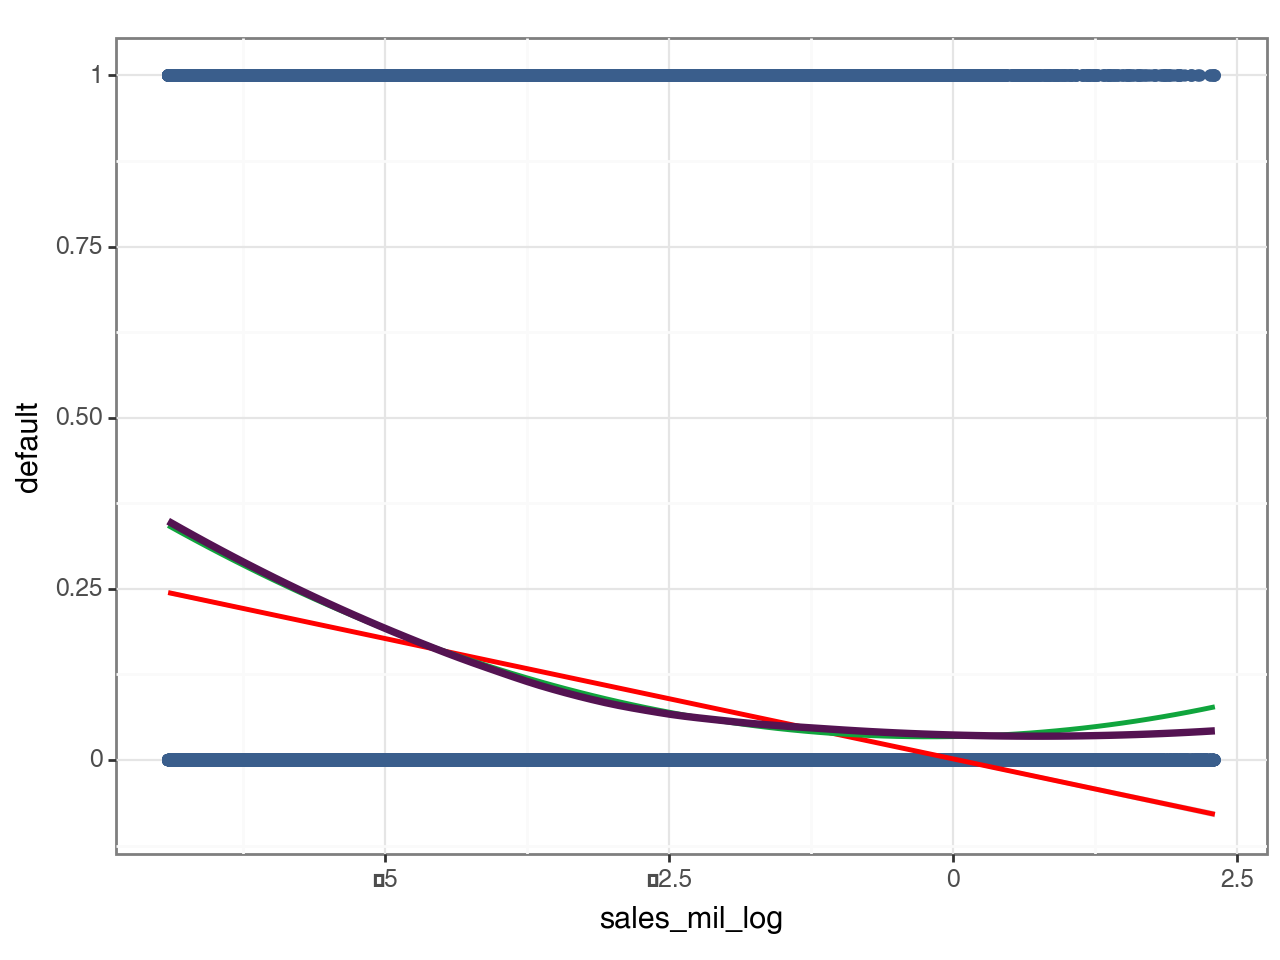

<Figure Size: (640 x 480)>

In [52]:
(
    ggplot(data, aes(x="sales_mil_log", y="default"))
    + geom_point(color=color[0])
    + geom_smooth(method = 'lm',color = 'red')
    + geom_smooth(method="lm", formula="y ~ x + I(x**2)", color=color[1], se=False)
    + geom_smooth(method="loess", color=color[2], se=False, size=1.5, span=0.9)
    + labs(x="sales_mil_log", y="default")
    + theme_bw()
)

In [53]:
# Linear regressions
ols_s = smf.ols("default ~ sales_mil_log + sales_mil_log_sq", data=data).fit()
print(ols_s.summary())

                            OLS Regression Results                            
Dep. Variable:                default   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     4674.
Date:                Wed, 28 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:19:22   Log-Likelihood:                -44159.
No. Observations:              197242   AIC:                         8.832e+04
Df Residuals:                  197239   BIC:                         8.836e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0343      0.002  

In [54]:
########################################################################
# sales change
########################################################################
# Note: graphs not in book

# lowess
data['d1_sales_mil_log'].describe(percentiles=[0.01, 0.05, 0.95, 0.99])

count    197242.000000
mean          0.017818
std           0.636712
min          -7.967947
1%           -1.943162
5%           -0.743172
50%           0.000000
95%           0.740446
99%           2.248594
max          12.420648
Name: d1_sales_mil_log, dtype: float64

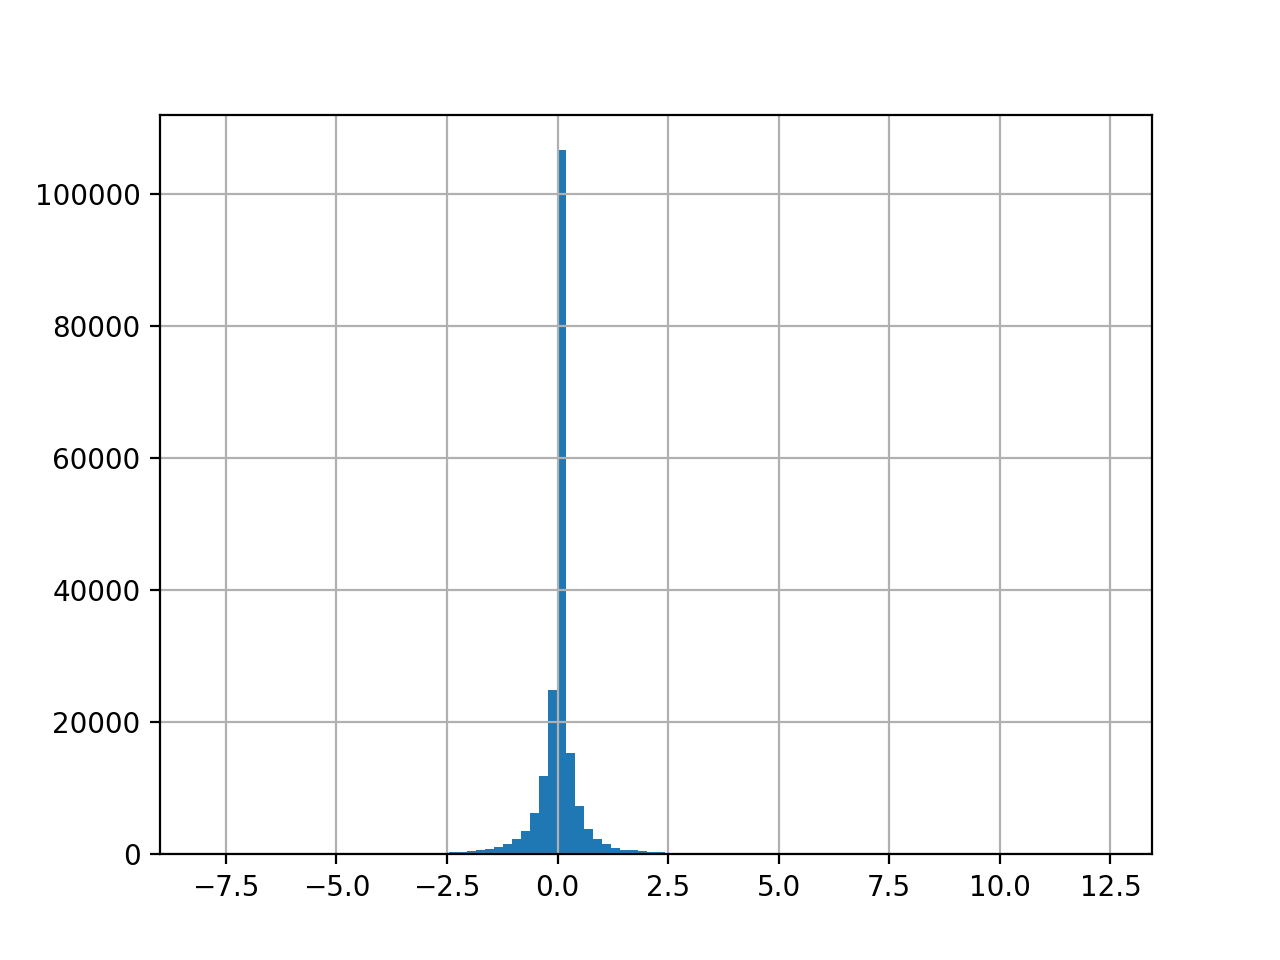

In [55]:
data['d1_sales_mil_log'].hist(bins=100)
plt.show()

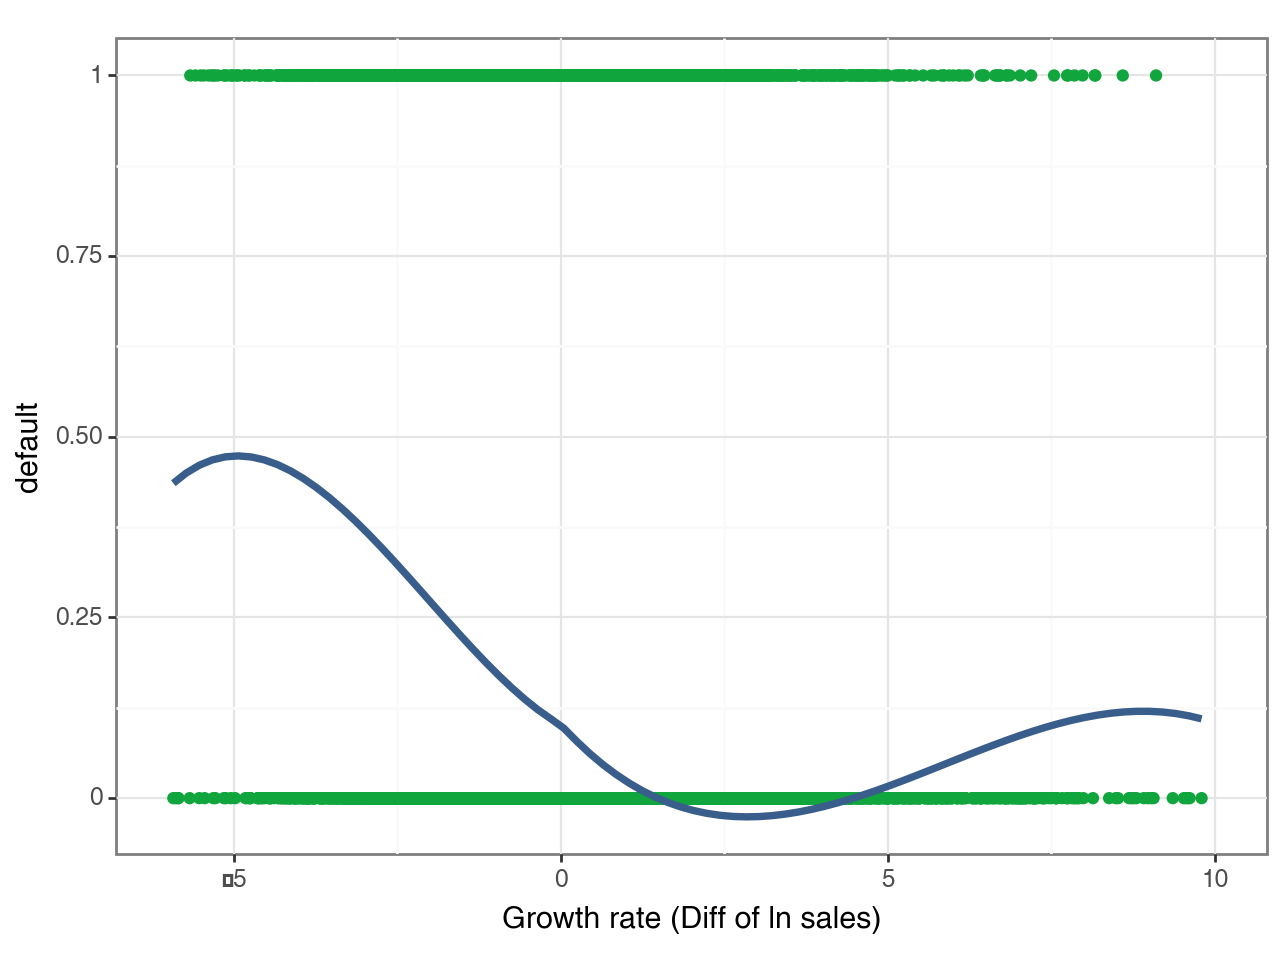

<Figure Size: (640 x 480)>

In [56]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="default"))
    + geom_point(color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="default")
    + scale_x_continuous(limits=(-6, 10), breaks=seq(-5, 10, by=5))
    + theme_bw()
)

In [57]:
(
    ggplot(data, aes(x="d1_sales_mil_log_mod", y="default"))
    + geom_point(color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="default")
    + scale_x_continuous(limits=(-6, 10), breaks=seq(-5, 10, by=5))
    + theme_bw()
)

PlotnineError: "Could not evaluate the 'x' mapping: 'd1_sales_mil_log_mod' (original error: name 'd1_sales_mil_log_mod' is not defined)"

In [58]:
# generate variables ---------------------------------------------------

data["flag_low_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] < -1.5, 1, 0)
data["flag_high_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] > 1.5, 1, 0)
data["d1_sales_mil_log_mod"] = np.where(
    data["d1_sales_mil_log"] < -1.5,
    -1.5,
    np.where(data["d1_sales_mil_log"] > 1.5, 1.5, data["d1_sales_mil_log"]),
)
data["d1_sales_mil_log_mod_sq"] = data["d1_sales_mil_log_mod"] ** 2

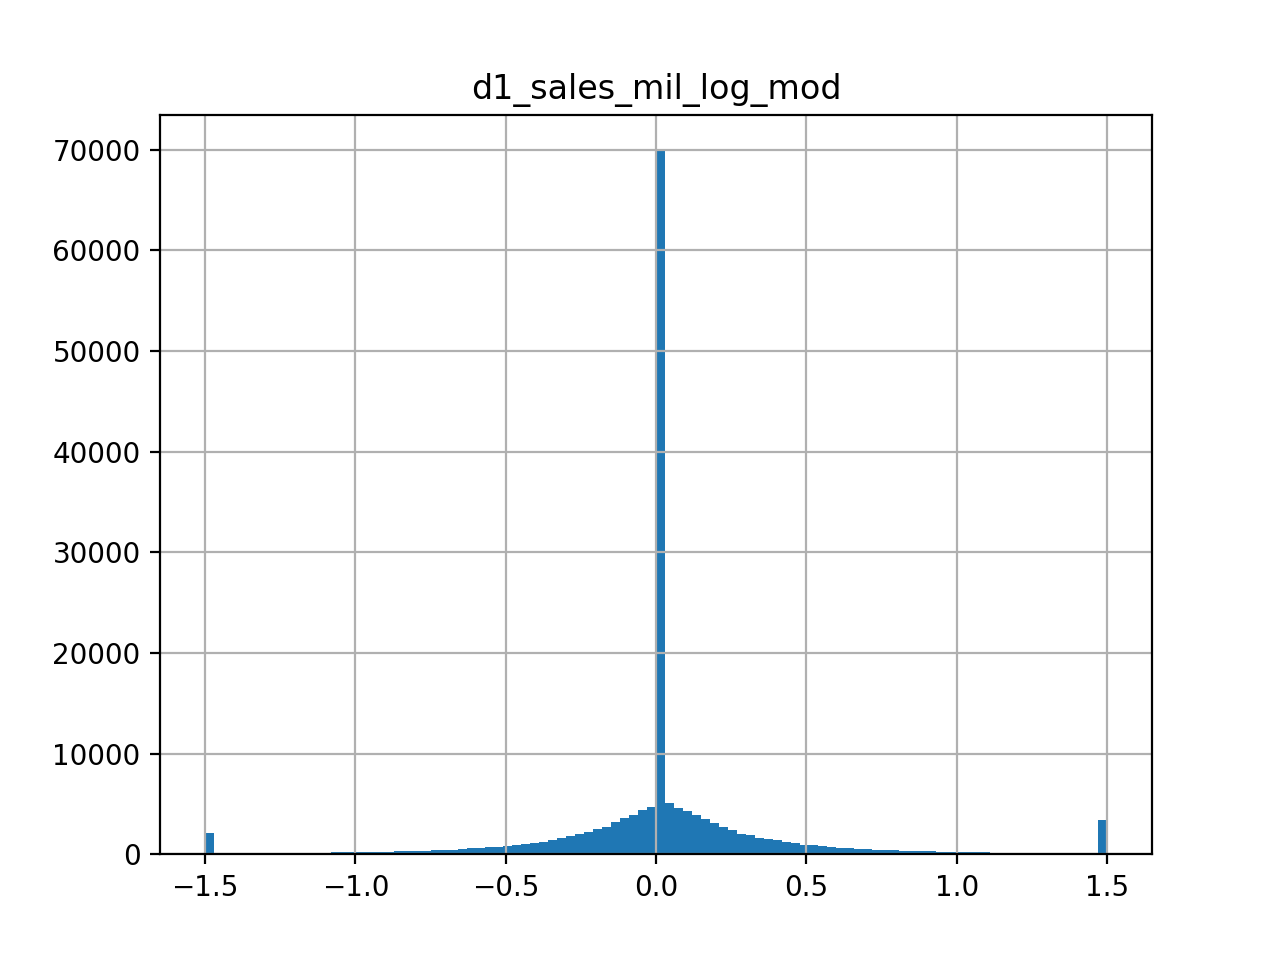

In [59]:
data.loc[data['default']== 0].hist("d1_sales_mil_log_mod",bins=100)
plt.show()

In [60]:
# no more imputation, drop obs if key vars missing
# data = data.dropna(subset=["liq_assets_bs", "foreign", "ind"])

# ha ezt belerakjuk akkor elcsúszik a holdout set megvizsgáltam úgy hogy előtte beillesztettem a holdout set-es részt és utána is

In [61]:
# drop missing
# data = data.dropna(subset=["age", "foreign", "material_exp_pl", "m_region_loc"])
data["age"].describe()

# ha ezt belerakjuk akkor elcsúszik a holdout set megvizsgáltam úgy hogy előtte beillesztettem a holdout set-es részt és utána is


count    157142.000000
mean          8.704000
std           6.312623
min           0.000000
25%           3.000000
50%           8.000000
75%          14.000000
max          63.000000
Name: age, dtype: float64

In [62]:
data[["age", "foreign", "material_exp_pl", "m_region_loc", "liq_assets_bs", "foreign", "ind"]].isna().sum()

age                40100
foreign            40077
material_exp_pl      334
m_region_loc         562
liq_assets_bs         77
foreign            40077
ind                 6885
dtype: int64

In [63]:
# drop unused factor levels
for col in data.select_dtypes(include=["category"]).columns:
    data[col] = data[col].cat.remove_unused_categories()

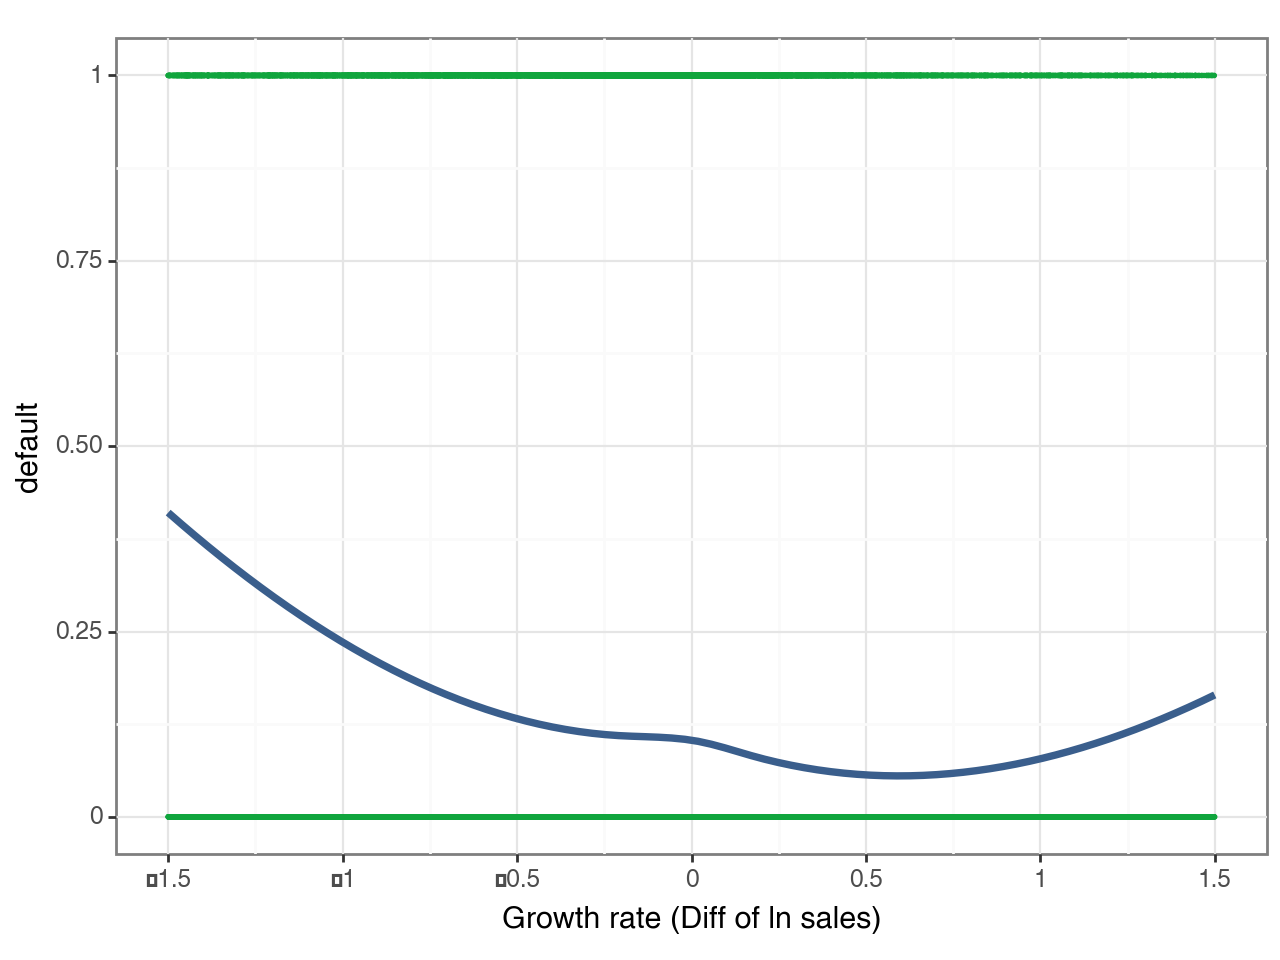

<Figure Size: (640 x 480)>

In [64]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="default"))
    + geom_point(size=0.1, color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="default")
    + scale_x_continuous(limits=(-1.5, 1.5), breaks=seq(-1.5, 1.5, by=0.5))
    + theme_bw()
)

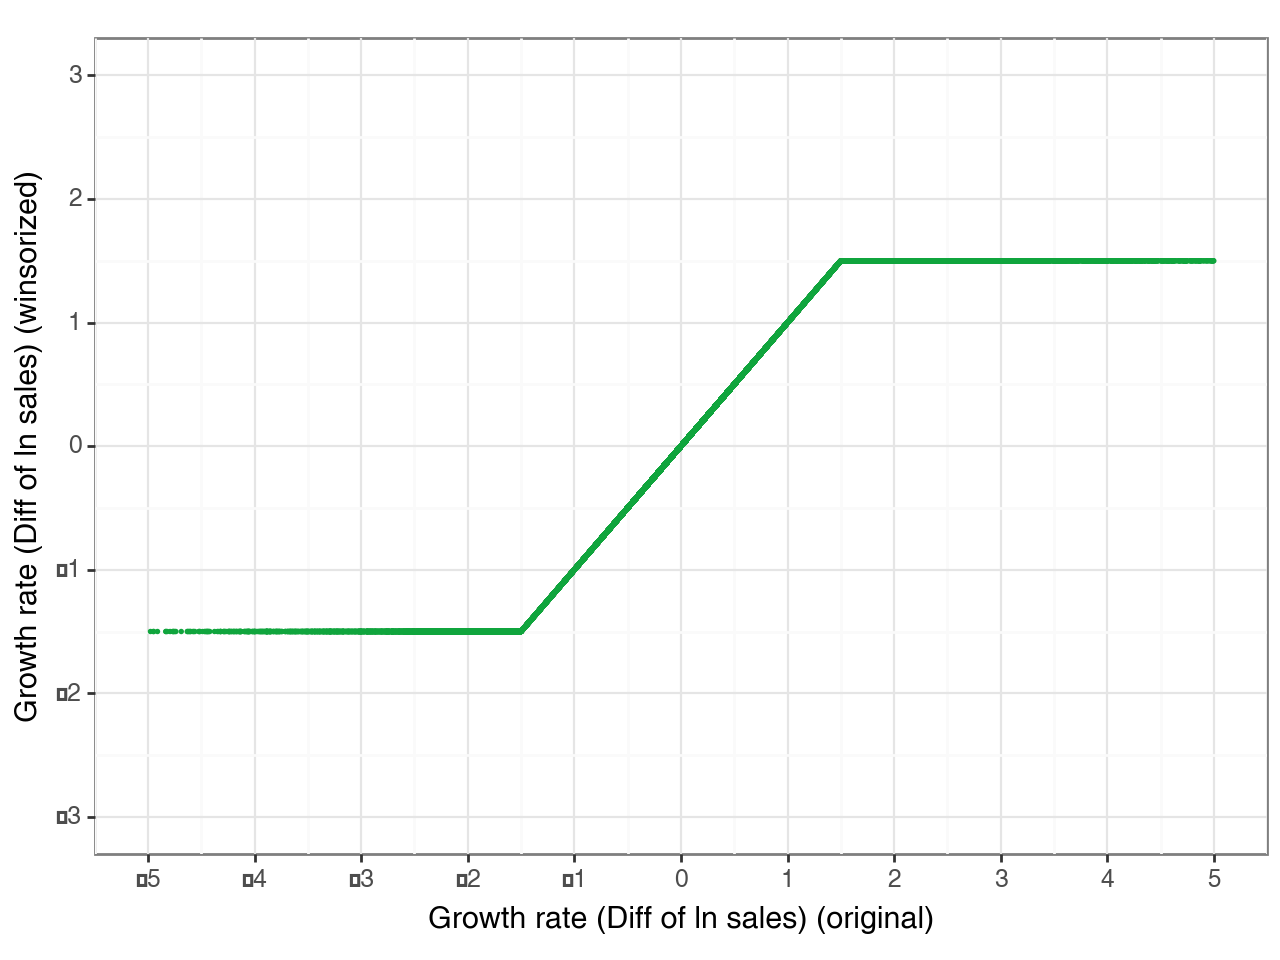

<Figure Size: (640 x 480)>

In [65]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="d1_sales_mil_log_mod"))
    + geom_point(size=0.1, color=color[1])
    + labs(
        x="Growth rate (Diff of ln sales) (original)",
        y="Growth rate (Diff of ln sales) (winsorized)",
    )
    + scale_x_continuous(limits=(-5, 5), breaks=seq(-5, 5, by=1))
    + scale_y_continuous(limits=(-3, 3), breaks=seq(-3, 3, by=1))
    + theme_bw()
)

In [66]:
# look at firms below 10m euro revenues and above 1000 euros (SME filtering)
#data = data.loc[(data['sales'] >= 1000) & (data['sales'] <= 10000000)]

# EDA

In [67]:
data[['year','comp_id']].groupby('year').nunique()

,comp_id
year,
2005,16111
2006,16420
2007,17821
2008,19058
2009,20541
2010,21166
2011,21648
2012,21723
2013,21464


In [68]:
data[['year','default','status_alive']].groupby('year').sum()

,default,status_alive
year,,
2005,1698,16111
2006,1345,16420
2007,1782,17821
2008,1761,19058
2009,2341,20541
2010,2664,21166
2011,2598,21648
2012,2589,21723
2013,2298,21464


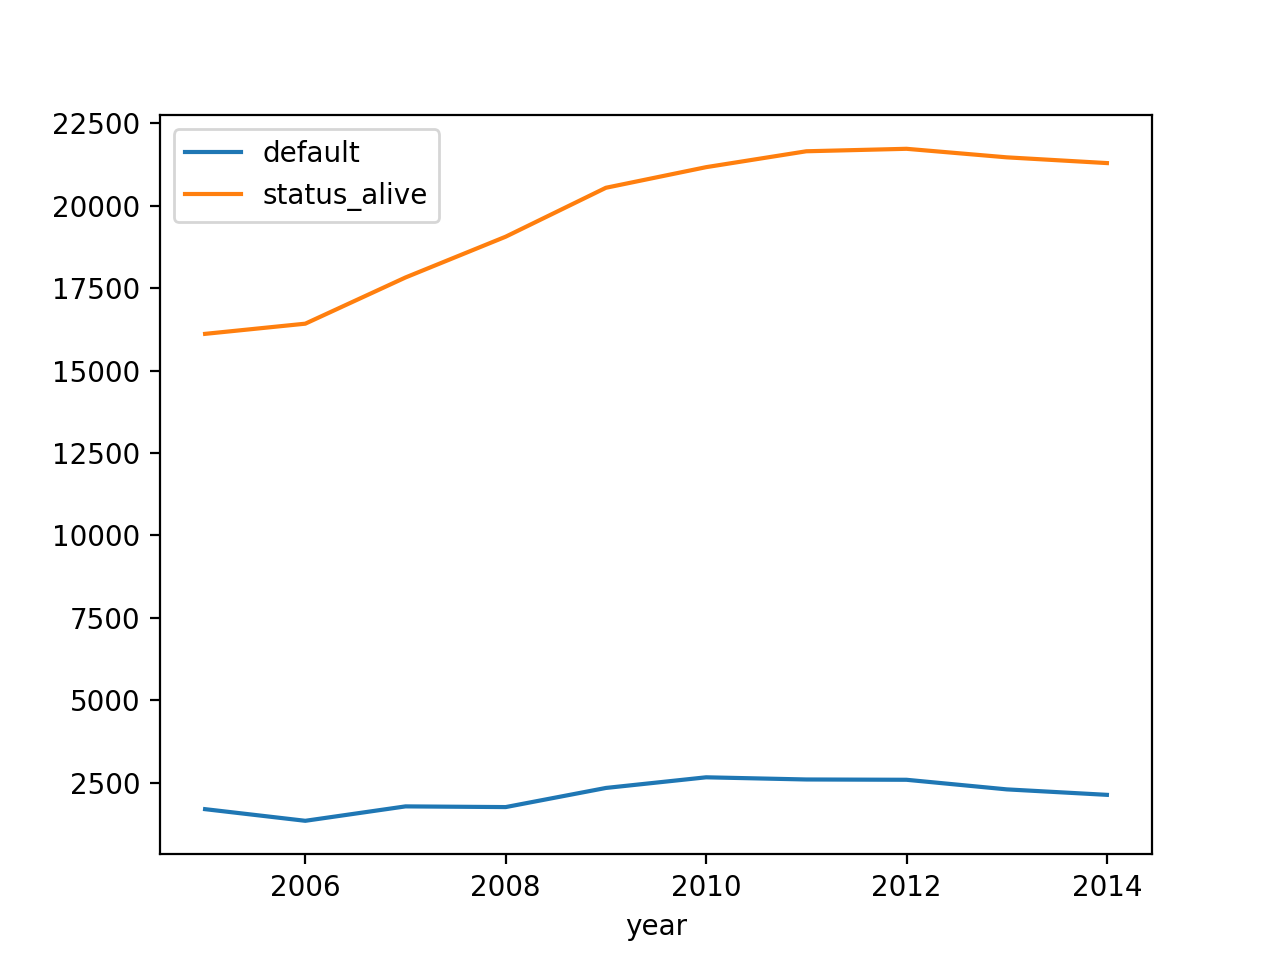

In [69]:
data[['year','default','status_alive']].groupby('year').sum().plot(kind='line')
plt.show()

In [70]:
data.default.mean()

0.1075227385648087

# Construction of the holdout set

We are only interested in predicting default for ‘ind2 == 26’, which is the selected industry, and the
firm is a small or medium enterprise (SME). Thus, yearly sales in 2014 was between 1000 EUR and 10
million EUR.

Existed in 2014 (sales > 0), but did not exists in 2015 (sales is 0 or missing)

If you do the sample design properly:
- you have an overall of 1037 firms.
- 56 firms defaulted
- 981 stayed alive. 
- The average sales of the firms is 0.4902 million EUR, with the minimum of 0.00107 million
EUR and 9.57648 million EUR.

In [71]:
# Creating the holdout set
holdout_set = data.loc[(data['ind2'] == 26) & (data['year'] == 2014) & (data['sales'] >= 1000) & (data['sales'] <= 10000000)]

# Display information about the resulting holdout set
print("Total firms in holdout set:", len(holdout_set))
print("Number of defaulted firms:", len(holdout_set[holdout_set['default'] == 1]))
print("Number of firms that stayed alive:", len(holdout_set[holdout_set['default'] == 0]))  # Since all firms meet the condition
print("Average sales of the firms:", holdout_set['sales'].mean())
print("Minimum sales:", holdout_set['sales'].min())
print("Maximum sales:", holdout_set['sales'].max())

Total firms in holdout set: 1037
Number of defaulted firms: 56
Number of firms that stayed alive: 981
Average sales of the firms: 490202.21792682
Minimum sales: 1070.370361328125
Maximum sales: 9576485.0



# Kérdések
- jó e az a szűrés hogy ind2 csak 26, nem lehet se empty se semmi más
- 1 évet nézünk vagy többet?
    - ha többet nézünk akkor rakhatnánk bele olyan változókat amik valamiféle trendeket, változásokat vagy több éven keresztüli átlagokat mutatnak
    - ha több évet nézünk akkor mi lesz azokkal a cégekkel, amik defaultolnak? bentmaradnak végig a táblázatban nan adatokkal - erre kéne egy szűrés, hogy kiessenek, de nem tudom melyik az a lépés ahol ennek ki kell jöbbie!

- SME sales-t vizsgálni
- CEU age 75? sokallom
    - itt olyan gondolatom van hogy majd a modellek fine tuneolálásnál az ilyen apró dolgok megváltoztatásával tudjuk egyedivé tenni a modellt
- Milyen hatása van az stack unstacknek? igazából csinál egy csomó NA sort, de ez alapján nem szabad megítélni h melyik sorban mennyi a hiányzó érték, inkább a default+aliveval lehetne talán - az se biztos, hogy jó
- a két dropos részt be kell raknunk valahova mert szerintem a nanok amiatt maradnak bent, de mi van ha a holdoutban van nan? akkor lehet predictálni, ahhoz nem kell h meglegyen az értékelk??



# Végig Gáborén favágással, nézzük meg mi jön ki minden finomhagolás nélkül!
nem sikerült, kurvasok hibára futottam, megpróbálom péterét

In [72]:
import os
import pandas as pd
import numpy as np
import sys
import patsy
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import sklearn.metrics as metrics
from sklearn.metrics import brier_score_loss, roc_curve, auc, confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

## Define helper functions

In [73]:
# Péter
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def create_coef_matrix(X, model):
    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns),pd.DataFrame(model.coef_.flatten())], axis = 1
    )
    coef_matrix.columns = ['variable', 'coefficient']
    coef_matrix.iloc[-1] = ['Intercept', model.intercept_.flatten()[0]]
    return coef_matrix

def cv_summary(lambdas, C_values, model):
    d = {'lambdas': lambdas, 'C_values': C_values, 'mean_cv_score': model.scores_[1].mean(axis = 0)}
    return(pd.DataFrame(data=d))

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr')) \
        + geom_line(color=color[0], size = 0.7) \
        + geom_area(position = 'identity', fill = 'mediumaquamarine', alpha = 0.3) \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)

def sigmoid_array(x):
    return(1 / (1 + np.exp(-x)))

def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold,param_index,:]
    return(sigmoid_array(np.dot(X, np.transpose(fold_coef)[:-1]) +  np.transpose(fold_coef)[-1]))

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy.false_pos*FP + all_coords_copy.false_neg*FN)/all_coords_copy.n
    
    t = optimal_threshold
    l = curr_exp_loss
    
    plot = ggplot(all_coords_copy, aes(x = 'thresholds', y = 'loss')) + \
        geom_line(color=color[0], size=0.7) + \
        scale_x_continuous(breaks = seq(0, 1.1, by = 0.1)) + \
        coord_cartesian(xlim=(0,1))+ \
        geom_vline(xintercept = t , color = color[0] ) + \
        annotate(geom = "text", x = t - 0.01, y= max(all_coords_copy.loss) - 0.4,
                 label="best threshold: " + str(round(t,2)),
                 colour=color[1], angle=90, size = 7) +\
        annotate(geom = "text", x = t + 0.06, y= l,\
                 label= str(round(l, 2)), size = 7) +\
        theme_bw()
    return(plot)


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = ggplot(all_coords_copy, aes(x = 'sp', y = 'se')) +\
        geom_line(color=color[0], size=0.7) +\
        scale_y_continuous(breaks = seq(0, 1.1, by = 0.1)) +\
        scale_x_reverse(breaks = seq(0, 1.1, by = 0.1)) +\
        geom_point(data = pd.DataFrame({'sp': [sp], 'se': [se]})) +\
        annotate(geom = "text", x = sp, y = se + 0.03,
                 label = str(round(sp, 2)) + ', ' + str(round(se, 2)), size = 7) +\
        theme_bw()
    return(plot)


In [74]:
data.isna().sum()

year                            0
comp_id                         0
begin                           0
end                             0
amort                         334
                             ... 
sales_mil_log_sq                0
flag_low_d1_sales_mil_log       0
flag_high_d1_sales_mil_log      0
d1_sales_mil_log_mod            0
d1_sales_mil_log_mod_sq         0
Length: 115, dtype: int64

In [75]:
data = data.dropna() # itt majd inkább impute

In [76]:
# drop unused factor levels
for col in data.select_dtypes(include=["category"]).columns:
    data[col] = data[col].cat.remove_unused_categories()

In [77]:
#data['ind2_cat'] = data['ind2_cat'].astype("category")

In [78]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if 'flag' in col]
data = data.drop(data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1)

In [79]:
data.shape

(115237, 114)

## Define variable sets

In [80]:
#data = data.loc[data['year'] == 2014] # teszt, majd kivenni

In [81]:
rawvars = ["curr_assets", "curr_liab", "extra_exp", "extra_inc", "extra_profit_loss", "fixed_assets",
              "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp",
              "profit_loss_year", "sales", "share_eq", "subscribed_cap"]
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
# engineered variables
engvar = ["total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
            "share_eq_bs", "subscribed_cap_bs", "intang_assets_bs", "extra_exp_pl",
            "extra_inc_pl", "extra_profit_loss_pl", "inc_bef_tax_pl", "inventories_pl",
            "material_exp_pl", "profit_loss_year_pl", "personnel_exp_pl"]
engvar2 = ["extra_profit_loss_pl_quad", "inc_bef_tax_pl_quad",
             "profit_loss_year_pl_quad", "share_eq_bs_quad"]
engvar3 = []
for col in data.columns:
    if col.endswith('flag_low') or col.endswith('flag_high') or col.endswith('flag_error') or col.endswith('flag_zero'):
        engvar3.append(col)


d1 =  ["d1_sales_mil_log_mod", "d1_sales_mil_log_mod_sq",
         "flag_low_d1_sales_mil_log", "flag_high_d1_sales_mil_log"]
hr = ["female", "ceo_age", "flag_high_ceo_age", "flag_low_ceo_age",
        "ceo_count", "labor_avg_mod",
        "flag_miss_labor_avg", "foreign_management"] # "flag_miss_ceo_age" deleted no variance

In [82]:
data.ind2_cat.value_counts()

56.0    66972
55.0    12224
28.0    11995
33.0    10924
26.0     6793
27.0     3880
29.0     1530
30.0      919
Name: ind2_cat, dtype: int64

In [83]:
#Creat dummy columns from category variables and drop first level
ind2_catmat = patsy.dmatrix("0 + C(ind2_cat)",data, return_type="dataframe")

In [84]:
ind2_catmat

,C(ind2_cat)[26.0],C(ind2_cat)[27.0],C(ind2_cat)[28.0],C(ind2_cat)[29.0],C(ind2_cat)[30.0],C(ind2_cat)[33.0],C(ind2_cat)[55.0],C(ind2_cat)[56.0]
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
464106,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
464110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
464112,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
464114,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [85]:
ind2_catmat = ind2_catmat.drop(['C(ind2_cat)[26.0]'], axis=1)

In [86]:
data.m_region_loc.value_counts()

Central    66934
East       29410
West       18893
Name: m_region_loc, dtype: int64

In [87]:
m_region_locmat = patsy.dmatrix("0 + C(m_region_loc)",data, return_type="dataframe")
m_region_locmat = m_region_locmat.drop(['C(m_region_loc)[Central]'], axis=1)

In [88]:
data.urban_m.value_counts()

3.0    46369
1.0    35746
2.0    33122
Name: urban_m, dtype: int64

In [89]:
urban_mmat = patsy.dmatrix("0 + C(urban_m)",data, return_type="dataframe")
urban_mmat = urban_mmat.drop(['C(urban_m)[1.0]'], axis=1)

In [90]:
# Define X1
basevars = data[["sales_mil_log", "sales_mil_log_sq", "d1_sales_mil_log_mod", "profit_loss_year_pl"]]
X1 = pd.concat([basevars, ind2_catmat], axis=1)

# Define X2
X2additional_vars = data[["fixed_assets_bs", "share_eq_bs","curr_liab_bs", "curr_liab_bs_flag_high", \
                          "curr_liab_bs_flag_error",  "age", "foreign_management"]]
X2 = pd.concat([X1, X2additional_vars], axis=1)

# Define X3
firm = pd.concat([data[["age", "age2", "new"]], ind2_catmat, m_region_locmat, urban_mmat], axis=1)
X3 = pd.concat([data[["sales_mil_log", "sales_mil_log_sq"] + engvar + d1], firm], axis=1)

# Define X4
X4 = pd.concat([data[["sales_mil_log", "sales_mil_log_sq"] + engvar + d1 \
                                 + engvar2 + engvar3 + hr + qualityvars], firm], axis=1)

In [91]:
# Define X5

#Creat matrix for interactions1 variables
int1mat = patsy.dmatrix("0 + C(ind2_cat):age + C(ind2_cat):age2 + C(ind2_cat):d1_sales_mil_log_mod \
                + C(ind2_cat):sales_mil_log + C(ind2_cat):ceo_age + C(ind2_cat):foreign_management \
                + C(ind2_cat):female + C(ind2_cat):C(urban_m) + C(ind2_cat):labor_avg_mod", 
                        data, return_type="dataframe")

#Drop first level to get k-1 dummies out of k categorical levels 
for col in int1mat.columns:
    if col.startswith('C(ind2_cat)[26]') or col.endswith('C(urban_m)[1]'):
        int1mat = int1mat.drop([col], axis=1)
        
#Creat matrix for interactions2 variables        
int2mat = patsy.dmatrix("0 + sales_mil_log:age + sales_mil_log:female + sales_mil_log:profit_loss_year_pl \
                + sales_mil_log:foreign_management", 
                        data, return_type="dataframe")

X5 = pd.concat([X4, int1mat, int2mat], axis=1)

In [92]:
# Define logitvars for LASSO
logitvars = pd.concat([X4, int1mat, int2mat], axis=1)

In [93]:
# Define rfvars for RF (no interactions, no modified features)
rfvars  = pd.concat([data[["sales_mil", "d1_sales_mil_log"] + rawvars + hr + qualityvars], firm], axis=1)

In [94]:
y = data['default']

### Simple linear and logistic models

In [95]:
ols_modelx1 = LinearRegression().fit(X1, y)

In [96]:
regression_results(y, ols_modelx1.predict(X1))

explained_variance:  0.0662
r2:  0.0662
MAE:  0.1393
MSE:  0.0685
RMSE:  0.2617


In [97]:
create_coef_matrix(X1, ols_modelx1)

,variable,coefficient
0,sales_mil_log,0.012609
1,sales_mil_log_sq,0.006122
2,d1_sales_mil_log_mod,-0.042846
3,profit_loss_year_pl,-0.082053
4,C(ind2_cat)[27.0],0.007556
5,C(ind2_cat)[28.0],0.008787
6,C(ind2_cat)[29.0],0.016436
7,C(ind2_cat)[30.0],0.002729
8,C(ind2_cat)[33.0],0.003837
9,C(ind2_cat)[55.0],0.001659


In [98]:
glm_modelx1 = LogisticRegression(
    solver="newton-cg",max_iter=1000, penalty="none", random_state = 20240205).fit(X1, y)
regression_results(y, glm_modelx1.predict(X1))

explained_variance:  -0.0042
r2:  -0.0843
MAE:  0.0795
MSE:  0.0795
RMSE:  0.282


In [99]:
create_coef_matrix(X1, glm_modelx1)

,variable,coefficient
0,sales_mil_log,-0.153115
1,sales_mil_log_sq,0.025843
2,d1_sales_mil_log_mod,-0.525503
3,profit_loss_year_pl,-0.697445
4,C(ind2_cat)[27.0],0.180470
5,C(ind2_cat)[28.0],0.166569
6,C(ind2_cat)[29.0],0.443269
7,C(ind2_cat)[30.0],0.063171
8,C(ind2_cat)[33.0],0.068707
9,C(ind2_cat)[55.0],0.179727


**Model X2**

In [100]:
glm_modelx2 = LogisticRegression(solver="newton-cg", max_iter=1000, penalty="none").fit(X2, y)
regression_results(y, glm_modelx2.predict(X2))

explained_variance:  -0.0042
r2:  -0.0792
MAE:  0.0792
MSE:  0.0792
RMSE:  0.2814


In [101]:
create_coef_matrix(X2, glm_modelx2)

,variable,coefficient
0,sales_mil_log,0.003854
1,sales_mil_log_sq,0.043198
2,d1_sales_mil_log_mod,-0.641737
3,profit_loss_year_pl,-0.361802
4,C(ind2_cat)[27.0],0.146370
5,C(ind2_cat)[28.0],0.149433
6,C(ind2_cat)[29.0],0.391116
7,C(ind2_cat)[30.0],-0.033234
8,C(ind2_cat)[33.0],-0.032715
9,C(ind2_cat)[55.0],0.338392


In [102]:
y

0         0
7         0
8         0
10        0
20        1
         ..
464106    0
464110    1
464112    0
464114    0
464118    0
Name: default, Length: 115237, dtype: int32

In [103]:
X2

,sales_mil_log,sales_mil_log_sq,d1_sales_mil_log_mod,profit_loss_year_pl,C(ind2_cat)[27.0],C(ind2_cat)[28.0],C(ind2_cat)[29.0],C(ind2_cat)[30.0],C(ind2_cat)[33.0],C(ind2_cat)[55.0],C(ind2_cat)[56.0],fixed_assets_bs,share_eq_bs,curr_liab_bs,curr_liab_bs_flag_high,curr_liab_bs_flag_error,age,foreign_management
0,-2.768567,7.664964,0.000000,0.001003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.144725,0.103749,0.891456,0.0,0.0,15.0,0.0
7,-1.373093,1.885384,0.000000,0.044388,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.957781,0.811766,0.006008,0.0,0.0,13.0,0.0
8,-2.318263,5.374343,0.000000,0.039917,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.651999,0.995107,0.012151,0.0,0.0,4.0,0.0
10,-2.288974,5.239404,0.000000,0.008111,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.096368,0.780468,0.210977,0.0,0.0,4.0,0.0
20,-4.538551,20.598441,0.000000,0.212405,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.916159,0.083841,0.0,0.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464106,-5.151815,26.541197,-0.911031,-0.352527,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.622598,-0.791955,1.000000,1.0,0.0,6.0,0.0
464110,-3.409902,11.627430,0.000000,0.110962,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.202931,0.348107,0.651893,0.0,0.0,0.0,0.0
464112,-0.797060,0.635305,0.196672,0.014308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.540033,0.394280,0.605177,0.0,0.0,19.0,0.0
464114,-2.939142,8.638555,-0.097370,0.029679,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.668968,0.923491,0.027759,0.0,0.0,8.0,0.0


In [104]:
mx2 = sm.Logit(y,sm.add_constant(X2)).fit().get_margeff()
print(mx2.summary())

Optimization terminated successfully.
         Current function value: 0.241240
         Iterations 8
        Logit Marginal Effects       
Dep. Variable:                default
Method:                          dydx
At:                           overall
                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
sales_mil_log               0.0003      0.002      0.149      0.882      -0.003       0.004
sales_mil_log_sq            0.0029      0.000     12.399      0.000       0.002       0.003
d1_sales_mil_log_mod       -0.0424      0.002    -28.025      0.000      -0.045      -0.039
profit_loss_year_pl        -0.0239      0.002    -10.931      0.000      -0.028      -0.020
C(ind2_cat)[27.0]           0.0097      0.007      1.431      0.153      -0.004       0.023
C(ind2_cat)[28.0]           0.0099      0.005      1.906      0.057      -0.000       0.020
C(ind2_cat

In [105]:
glm_modelx3 = LogisticRegression(solver="newton-cg", max_iter=1000, penalty="none").fit(X3, y)
regression_results(y, glm_modelx3.predict(X3))

explained_variance:  0.0
r2:  -0.0866
MAE:  0.0797
MSE:  0.0797
RMSE:  0.2823


In [106]:
create_coef_matrix(X3, glm_modelx3)

,variable,coefficient
0,sales_mil_log,4.279173e-11
1,sales_mil_log_sq,-1.543779e-10
2,total_assets_bs,-1.838693e-06
3,fixed_assets_bs,-5.825822e-12
4,liq_assets_bs,-3.235935e-12
5,curr_assets_bs,-9.116295e-12
6,share_eq_bs,-2.616507e-12
7,subscribed_cap_bs,-3.992678e-12
8,intang_assets_bs,-1.019807e-13
9,extra_exp_pl,-2.146059e-14


In [107]:
mx3 = sm.Logit(y,sm.add_constant(X3)).fit().get_margeff()
print(mx3.summary())

Optimization terminated successfully.
         Current function value: 0.234446
         Iterations 8
        Logit Marginal Effects       
Dep. Variable:                default
Method:                          dydx
At:                           overall
                                dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
sales_mil_log                  0.0016      0.002      0.932      0.351      -0.002       0.005
sales_mil_log_sq               0.0023      0.000      9.825      0.000       0.002       0.003
total_assets_bs             9.804e-10   6.08e-10      1.611      0.107   -2.12e-10    2.17e-09
fixed_assets_bs               -0.1631      0.009    -18.564      0.000      -0.180      -0.146
liq_assets_bs                  0.0095      0.003      3.138      0.002       0.004       0.015
curr_assets_bs                -0.1137      0.009    -12.927      0.000      -0.13

**Baseline model is X4 (all vars, but no interactions)**

In [108]:
ols_model = LinearRegression().fit(X4, y)
regression_results(y, ols_model.predict(X4))

explained_variance:  0.1203
r2:  0.1203
MAE:  0.1345
MSE:  0.0645
RMSE:  0.254


In [109]:
create_coef_matrix(X4, ols_model)

,variable,coefficient
0,sales_mil_log,1.583306e-02
1,sales_mil_log_sq,3.945659e-03
2,total_assets_bs,9.030307e-10
3,fixed_assets_bs,-3.400570e-01
4,liq_assets_bs,1.456673e-02
...,...,...
73,C(ind2_cat)[56.0],3.181551e-02
74,C(m_region_loc)[East],-1.508446e-03
75,C(m_region_loc)[West],-4.579231e-03
76,C(urban_m)[2.0],4.641587e-03


In [110]:
glm_model = LogisticRegression(solver="newton-cg",max_iter=1000, penalty="none").fit(X4, y)
regression_results(y, glm_model.predict(X4))

explained_variance:  0.0
r2:  -0.0866
MAE:  0.0797
MSE:  0.0797
RMSE:  0.2823


In [111]:
create_coef_matrix(X4, glm_model)

,variable,coefficient
0,sales_mil_log,4.279164e-11
1,sales_mil_log_sq,-1.543776e-10
2,total_assets_bs,-1.838689e-06
3,fixed_assets_bs,-5.825810e-12
4,liq_assets_bs,-3.235929e-12
...,...,...
73,C(ind2_cat)[56.0],-8.482769e-12
74,C(m_region_loc)[East],-3.874424e-12
75,C(m_region_loc)[West],-2.524887e-12
76,C(urban_m)[2.0],-4.316276e-12


In [112]:
data[["total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
            "share_eq_bs", "subscribed_cap_bs", "intang_assets_bs", "extra_exp_pl",
            "extra_inc_pl", "extra_profit_loss_pl", "inc_bef_tax_pl", "inventories_pl",
            "material_exp_pl", "profit_loss_year_pl", "personnel_exp_pl"]].describe(percentiles=[0.01, 0.05, 0.95, 0.99])

,total_assets_bs,fixed_assets_bs,liq_assets_bs,curr_assets_bs,share_eq_bs,subscribed_cap_bs,intang_assets_bs,extra_exp_pl,extra_inc_pl,extra_profit_loss_pl,inc_bef_tax_pl,inventories_pl,material_exp_pl,profit_loss_year_pl,personnel_exp_pl
count,1.152370e+05,115237.000000,115237.000000,115237.000000,115237.000000,115237.000000,115237.000000,115237.000000,115237.000000,115237.000000,115237.000000,115237.000000,115237.000000,115237.000000,115237.000000
mean,2.014352e+05,0.375896,0.220818,0.614831,0.117005,0.287743,0.006948,0.002255,0.013215,0.010949,-0.059935,0.095635,0.706047,-0.083525,0.277188
std,1.339202e+06,0.338228,0.270622,0.342762,0.667397,0.330192,0.040163,0.033664,0.087492,0.091068,0.348774,0.188274,0.236150,0.322392,0.226353
min,0.000000e+00,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000
1%,1.777778e+02,0.000000,0.000000,0.004669,-1.000000,0.000347,0.000000,0.000000,0.000000,-0.018391,-1.000000,0.000000,0.021401,-1.000000,0.000000
5%,1.325926e+03,0.000000,0.001774,0.034842,-1.000000,0.003278,0.000000,0.000000,0.000000,-0.000446,-0.974559,0.000000,0.209862,-0.976541,0.000000
50%,2.925926e+04,0.297012,0.098578,0.691439,0.269066,0.135833,0.000000,0.000000,0.000000,0.000000,0.011513,0.022936,0.740020,0.005114,0.234913
95%,7.830341e+05,0.960147,0.868855,1.000000,0.956881,1.000000,0.018777,0.001039,0.018377,0.015636,0.410576,0.475121,1.000000,0.281855,0.763305
99%,3.185719e+06,0.992846,1.000000,1.000000,1.000000,1.000000,0.223585,0.026064,0.444115,0.422808,0.940773,1.000000,1.000000,0.713799,1.000000
max,3.190691e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [113]:
data[["extra_profit_loss_pl_quad", "inc_bef_tax_pl_quad",
             "profit_loss_year_pl_quad", "share_eq_bs_quad"]].describe(percentiles=[0.01, 0.05, 0.95, 0.99])

,extra_profit_loss_pl_quad,inc_bef_tax_pl_quad,profit_loss_year_pl_quad,share_eq_bs_quad
count,115237.000000,115237.000000,1.152370e+05,115237.000000
mean,0.008413,0.125234,1.109124e-01,0.459105
std,0.077336,0.264907,2.528507e-01,0.382530
min,0.000000,0.000000,0.000000e+00,0.000000
1%,0.000000,0.000001,0.000000e+00,0.000047
5%,0.000000,0.000021,3.472404e-07,0.002622
50%,0.000000,0.008339,4.885189e-03,0.376791
95%,0.000754,1.000000,1.000000e+00,1.000000
99%,0.222240,1.000000,1.000000e+00,1.000000
max,1.000000,1.000000,1.000000e+00,1.000000


In [114]:
data[["d1_sales_mil_log_mod", "d1_sales_mil_log_mod_sq",
         "flag_low_d1_sales_mil_log", "flag_high_d1_sales_mil_log"]].describe(percentiles=[0.01, 0.05, 0.95, 0.99])

,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log
count,115237.000000,115237.000000,115237.000000,115237.000000
mean,0.015980,0.245747,0.020601,0.024168
std,0.495473,0.542460,0.142045,0.153570
min,-1.500000,0.000000,0.000000,0.000000
1%,-1.500000,0.000000,0.000000,0.000000
5%,-0.850305,0.000000,0.000000,0.000000
50%,0.000000,0.022436,0.000000,0.000000
95%,0.897176,1.971858,0.000000,0.000000
99%,1.500000,2.250000,1.000000,1.000000
max,1.500000,2.250000,1.000000,1.000000


In [115]:
# Get marginal effects
m = sm.Logit(y,sm.add_constant(X4)).fit().get_margeff()

Optimization terminated successfully.
         Current function value: 0.230573
         Iterations 8


In [116]:
print(m.summary())

        Logit Marginal Effects       
Dep. Variable:                default
Method:                          dydx
At:                           overall
                                    dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
sales_mil_log                     -0.0024      0.002     -1.193      0.233      -0.006       0.002
sales_mil_log_sq                   0.0015      0.000      5.686      0.000       0.001       0.002
total_assets_bs                 6.567e-10   4.49e-10      1.463      0.144   -2.23e-10    1.54e-09
fixed_assets_bs                   -0.1321      0.023     -5.777      0.000      -0.177      -0.087
liq_assets_bs                      0.0082      0.003      2.689      0.007       0.002       0.014
curr_assets_bs                    -0.0851      0.023     -3.719      0.000      -0.130      -0.040
share_eq_bs                       -0.0082      0.003    

**Keep significant variables only**

In [117]:
t = m.summary().tables[1]

In [118]:
t

,dy/dx,std err,z,P>|z|,[0.025,0.975]
sales_mil_log,-0.0024,0.002,-1.193,0.233,-0.006,0.002
sales_mil_log_sq,0.0015,0.000,5.686,0.000,0.001,0.002
total_assets_bs,6.567e-10,4.49e-10,1.463,0.144,-2.23e-10,1.54e-09
fixed_assets_bs,-0.1321,0.023,-5.777,0.000,-0.177,-0.087
liq_assets_bs,0.0082,0.003,2.689,0.007,0.002,0.014
curr_assets_bs,-0.0851,0.023,-3.719,0.000,-0.130,-0.040
share_eq_bs,-0.0082,0.003,-3.110,0.002,-0.013,-0.003
subscribed_cap_bs,0.0008,0.004,0.215,0.830,-0.006,0.008
intang_assets_bs,-0.0696,0.029,-2.423,0.015,-0.126,-0.013
extra_exp_pl,0.0676,0.061,1.108,0.268,-0.052,0.187


In [119]:
columns = pd.DataFrame(t.data).iloc[0].tolist()

In [120]:
df_marginal_effects = pd.DataFrame(t.data, columns = columns).iloc[1:].astype(
    {'dy/dx': float, 'P>|z|': float})
df_marginal_effects[df_marginal_effects['P>|z|'] <= 0.05].sort_values(by = 'dy/dx', ascending = False).reset_index(drop = True)

,,dy/dx,std err,z,P>|z|,[0.025,0.975]
0,extra_profit_loss_pl_flag_high,0.237700,0.088,2.700,0.007,0.065,0.410
1,extra_inc_pl,0.172400,0.064,2.708,0.007,0.048,0.297
2,balsheet_flag,0.119100,0.020,5.835,0.000,0.079,0.159
3,inc_bef_tax_pl_flag_zero,0.087800,0.013,6.870,0.000,0.063,0.113
4,liq_assets_bs_flag_error,0.085300,0.015,5.552,0.000,0.055,0.115
5,inc_bef_tax_pl_quad,0.076200,0.014,5.406,0.000,0.049,0.104
6,inventories_pl_flag_high,0.056900,0.007,7.770,0.000,0.043,0.071
7,profit_loss_year_pl,0.052500,0.012,4.501,0.000,0.030,0.075
8,d1_sales_mil_log_mod_sq,0.041000,0.002,20.190,0.000,0.037,0.045
9,C(ind2_cat)[56.0],0.037000,0.004,8.612,0.000,0.029,0.045


### Separate train and holdout data

In [263]:
data.reset_index(drop = True, inplace=True)

In [264]:

# Creating the holdout set
holdout = data.loc[(data['ind2'] == 26) & (data['year'] == 2014) & (data['sales'] >= 1000) & (data['sales'] <= 10000000)]

# Display information about the resulting holdout set
print("Total firms in holdout set:", len(holdout))
print("Number of defaulted firms:", len(holdout[holdout['default'] == 1]))
print("Number of firms that stayed alive:", len(holdout[holdout['default'] == 0]))  # Since all firms meet the condition
print("Average sales of the firms:", holdout['sales'].mean())
print("Minimum sales:", holdout['sales'].min())
print("Maximum sales:", holdout['sales'].max())

train = data.drop(holdout.index)

Total firms in holdout set: 921
Number of defaulted firms: 42
Number of firms that stayed alive: 879
Average sales of the firms: 371184.65251963196
Minimum sales: 1070.370361328125
Maximum sales: 9021607.0


In [265]:

#holdout = holdout.sample(frac=0.8)
train = train.sample(frac=0.1)

In [266]:
y_holdout = holdout['default']
y_train = train['default']
index_train = y_train.index
index_holdout = y_holdout.index

In [267]:
y_train 

56761     0
87750     0
24325     0
28464     0
84233     0
         ..
9686      0
104089    0
22202     0
22376     0
30946     0
Name: default, Length: 11432, dtype: int32

In [268]:
y_holdout

97458     0
97468     0
97486     0
97501     0
97503     0
         ..
115157    0
115186    0
115206    0
115209    0
115219    0
Name: default, Length: 921, dtype: int32

In [269]:
print('Total')
print(data['default'].value_counts(normalize=True))
print('Train')
print(train['default'].value_counts(normalize=True))
print('Holdout')
print(holdout['default'].value_counts(normalize=True))

Total
0    0.920286
1    0.079714
Name: default, dtype: float64
Train
0    0.919787
1    0.080213
Name: default, dtype: float64
Holdout
0    0.954397
1    0.045603
Name: default, dtype: float64


#### specify cross-validation method

In [270]:
k = KFold(n_splits = 5, shuffle = True, random_state = 20240205)

#### Logistic regression

In [271]:
# no regularisation needed so setting the paremeter to very high value
Cs_value_logit = [1e20]

In [272]:
logit_model_vars = [X1.iloc[index_train], X2.iloc[index_train], X3.iloc[index_train], X4.iloc[index_train], X5.iloc[index_train]]

logit_models = dict()
CV_RMSE_folds = dict()

In [273]:
%%time
for i in range(len(logit_model_vars)):
    LRCV_brier = LogisticRegressionCV(
        Cs=Cs_value_logit, 
        cv=k, # simply the number of folds
        refit=True, 
        scoring='neg_brier_score', 
        solver="newton-cg", 
        tol=1e-7, 
        random_state=20240205)
    logit_models['X'+str(i+1)] = LRCV_brier.fit(logit_model_vars[i], y_train)
    
    # Calculate RMSE on test for each fold
    CV_RMSE_folds['X'+str(i+1)] = np.sqrt(-1*(logit_models['X'+str(i+1)].scores_[1])).flatten()

CPU times: total: 1min 23s
Wall time: 21.7 s


In [274]:
pd.DataFrame(CV_RMSE_folds)

,X1,X2,X3,X4,X5
0,0.253177,0.248337,0.248906,0.246650,0.248336
1,0.277029,0.275360,0.358139,0.358109,0.358107
2,0.252749,0.248331,0.244598,0.243613,0.245094
3,0.257203,0.253089,0.353183,0.353148,0.353146
4,0.260567,0.258486,0.257718,0.257080,0.259052


#### Lasso logit

In [275]:
normalized_logitvars = pd.DataFrame(StandardScaler().fit_transform(logitvars.iloc[index_train]))
normalized_logitvars.columns = logitvars.columns

In [276]:
lambdas=list(10**np.arange(-1,-4.01, -1/3))
n_obs = normalized_logitvars.shape[0]*4/5
Cs_values = [1/(l*n_obs) for l in lambdas]

In [277]:
Cs_values

[0.0010934219734079775,
 0.0023557062303532664,
 0.005075215222197315,
 0.01093421973407977,
 0.023557062303532647,
 0.0507521522219731,
 0.10934219734079763,
 0.2355706230353265,
 0.5075215222197311,
 1.0934219734079753]

Training for ***accuracy***

In [278]:
logLasso = LogisticRegressionCV(
    Cs = Cs_values, 
    penalty = 'l1', # L1 makes it lasso
    cv = k, 
    refit = True, 
    scoring = 'accuracy', 
    solver = 'liblinear',
    random_state = 20240205)

In [279]:
%%time
logit_models["LASSO"] = logLasso.fit(normalized_logitvars, y_train)

CPU times: total: 51.5 s
Wall time: 56.9 s


In [280]:
cv_summary_lasso = cv_summary(lambdas, Cs_values, logit_models["LASSO"])
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.001093,0.919787
1,0.046416,0.002356,0.919787
2,0.021544,0.005075,0.920224
3,0.010000,0.010934,0.921274
4,0.004642,0.023557,0.921799
5,0.002154,0.050752,0.922499
6,0.001000,0.109342,0.921624
7,0.000464,0.235571,0.921362
8,0.000215,0.507522,0.921099
9,0.000100,1.093422,0.920837


In [281]:
best_lambda = cv_summary_lasso.sort_values('mean_cv_score', ascending = False).iloc[0,0]
best_lambda

0.002154434690031887

In [282]:
create_coef_matrix(normalized_logitvars, logit_models["LASSO"]).sort_values('coefficient', ascending = False)

,variable,coefficient
18,d1_sales_mil_log_mod_sq,0.300162
1,sales_mil_log_sq,0.258982
30,curr_liab_bs_flag_high,0.189618
22,inc_bef_tax_pl_quad,0.157131
44,share_eq_bs_flag_low,0.150879
...,...,...
13,inventories_pl,-0.196546
3,fixed_assets_bs,-0.210540
17,d1_sales_mil_log_mod,-0.234105
64,age,-0.273377


Training for ***Brier-score*** (aka RMSE)

In [283]:
#refit with negative brier score so we have RMSE values for the same cv split

logLasso_brier = LogisticRegressionCV(
    Cs = Cs_values, 
    penalty = 'l1', 
    cv = k, 
    refit = True, 
    scoring = 'neg_brier_score', 
    solver = "liblinear", 
    random_state = 20240205)
logLasso_brier_fitted = logLasso_brier.fit(normalized_logitvars, y_train)

In [284]:
for i, l in enumerate(lambdas):
    if l == best_lambda:
        best_lambda_i = i
        CV_RMSE_folds['LASSO'] = np.sqrt(-1*(logLasso_brier_fitted.scores_[1][:,i])).tolist()

In [285]:
pd.DataFrame(CV_RMSE_folds)

,X1,X2,X3,X4,X5,LASSO
0,0.253177,0.248337,0.248906,0.246650,0.248336,0.247006
1,0.277029,0.275360,0.358139,0.358109,0.358107,0.269577
2,0.252749,0.248331,0.244598,0.243613,0.245094,0.243524
3,0.257203,0.253089,0.353183,0.353148,0.353146,0.248749
4,0.260567,0.258486,0.257718,0.257080,0.259052,0.256520


### AUC using no loss fn

In [286]:
CV_AUC_folds = dict()

**refit logit models with AUC so we have AUC values for the same cv split**

Training for ***AUC***

In [287]:
for i in range(len(logit_model_vars)):
    LRCV_auc = LogisticRegressionCV(
        Cs=Cs_value_logit, 
        cv=k, 
        refit=True, 
        scoring='roc_auc', 
        solver="newton-cg", 
        tol=1e-7, 
        random_state = 20240205)
    LRCV_auc_fit = LRCV_auc.fit(logit_model_vars[i], y_train)
    # Calculate AUC on test for each fold
    CV_AUC_folds['X'+str(i+1)] = LRCV_auc_fit.scores_[1][:,0].tolist()

In [288]:
pd.DataFrame(CV_AUC_folds)

,X1,X2,X3,X4,X5
0,0.776186,0.802571,0.816295,0.813517,0.798593
1,0.688653,0.737398,0.674361,0.674370,0.674370
2,0.742351,0.791906,0.807528,0.819005,0.813830
3,0.727657,0.772949,0.684324,0.684324,0.684314
4,0.743565,0.773447,0.781885,0.792940,0.783544


In [289]:
%%time
#refit with AUC so we have AUC values for the same cv split

logLasso_auc = LogisticRegressionCV(
    Cs=Cs_values, 
    penalty='l1', 
    cv=k, 
    refit=True, scoring='roc_auc', 
    solver="liblinear", 
    random_state = 20240205)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)
CV_AUC_folds['LASSO'] = logLasso_auc_fitted.scores_[1][:,best_lambda_i].tolist()

CPU times: total: 54.1 s
Wall time: 57.5 s


In [290]:
pd.DataFrame(CV_AUC_folds)

,X1,X2,X3,X4,X5,LASSO
0,0.776186,0.802571,0.816295,0.813517,0.798593,0.808638
1,0.688653,0.737398,0.674361,0.674370,0.674370,0.770363
2,0.742351,0.791906,0.807528,0.819005,0.813830,0.825819
3,0.727657,0.772949,0.684324,0.684324,0.684314,0.809499
4,0.743565,0.773447,0.781885,0.792940,0.783544,0.791987


**For each model: average RMSE and average AUC for models**

In [291]:
CV_RMSE = dict()
CV_AUC = dict()
nvars = dict()

In [292]:
for key in logit_models:
    CV_RMSE[key] = np.mean(CV_RMSE_folds[key])
    CV_AUC[key] = np.mean(CV_AUC_folds[key])  

In [293]:
CV_AUC

{'X1': 0.7356824125225471,
 'X2': 0.7756540554791542,
 'X3': 0.7528785686245578,
 'X4': 0.7568313569273589,
 'X5': 0.7509299672889437,
 'LASSO': 0.8012611182658637}

In [294]:
for key in logit_models:
    if key != 'LASSO':
        nvars[key] = logit_models[key].n_features_in_
    else:
        nvars[key] = sum(x != 0 for x in logit_models[key].coef_[0].tolist())

In [295]:
logLasso.coef_

array([[ 0.        ,  0.25898205, -0.03047067, -0.21054012,  0.        ,
         0.        ,  0.        ,  0.        , -0.01214144,  0.00708427,
         0.        ,  0.        , -0.00908492, -0.19654574,  0.        ,
         0.        , -0.02972538, -0.23410536,  0.30016201, -0.0715231 ,
         0.04502387,  0.        ,  0.15713098,  0.        ,  0.01403833,
         0.02145495,  0.02589858,  0.08263094,  0.00967439,  0.        ,
         0.18961806,  0.01932144,  0.08853701,  0.        ,  0.03082002,
         0.00031314,  0.        ,  0.        ,  0.00703555,  0.06790245,
         0.        , -0.00932658,  0.        , -0.0064188 ,  0.15087899,
         0.        ,  0.00584034,  0.01153624,  0.        ,  0.        ,
         0.00750751, -0.0165206 ,  0.06966674, -0.02612045,  0.        ,
         0.        ,  0.02374326,  0.        ,  0.        , -0.13711588,
         0.        ,  0.04898941,  0.        ,  0.00339289, -0.27337687,
         0.        ,  0.11365688,  0.        , -0.0

In [296]:
nvars

{'X1': 11, 'X2': 18, 'X3': 35, 'X4': 78, 'X5': 170, 'LASSO': 71}

<br>

We have 6 models, (5 logit and the logit lasso). For each we have a 5-CV RMSE and AUC.
We pick our preferred model based on that.

In [297]:
logit_summary1 = np.transpose(pd.DataFrame.from_dict([nvars,CV_RMSE,CV_AUC], orient='columns'))
logit_summary1.columns = ['Number of predictors', 'CV RMSE', 'CV AUC']

In [298]:
logit_summary1

,Number of predictors,CV RMSE,CV AUC
X1,11.0,0.260145,0.735682
X2,18.0,0.256721,0.775654
X3,35.0,0.292509,0.752879
X4,78.0,0.291720,0.756831
X5,170.0,0.292747,0.750930
LASSO,71.0,0.253075,0.801261


Take best model and estimate RMSE on holdout
X4, X5 and LASSO are practically the same - go with the simplest model 

In [299]:
best_model = logit_models['X4']
best_model_X_holdout = X4.iloc[index_holdout]

logit_predicted_probabilities_holdout = best_model.predict_proba(best_model_X_holdout)[:,1]
best_rmse_holdout = np.sqrt(metrics.mean_squared_error(y_holdout, logit_predicted_probabilities_holdout))
round(best_rmse_holdout, 3)

0.196

In [300]:
logit_predicted_probabilities_holdout

array([1.00111568e-02, 7.69686460e-03, 3.11363638e-01, 8.41385882e-03,
       2.17899123e-02, 2.45296214e-02, 2.86806781e-02, 4.45925996e-02,
       2.20099459e-02, 1.64636880e-02, 3.84555556e-02, 1.39685526e-02,
       1.22339042e-02, 8.00113678e-03, 1.68658669e-02, 1.76083149e-02,
       7.90893337e-03, 2.37451613e-02, 7.43555914e-02, 2.04251002e-02,
       4.72383718e-03, 6.15686898e-03, 8.88111189e-02, 5.64006618e-03,
       3.01716894e-02, 1.36206971e-02, 1.36063342e-02, 3.58105246e-03,
       2.20128450e-02, 5.59907627e-02, 1.00267886e-02, 1.70172153e-02,
       5.72883548e-03, 5.06668699e-03, 3.03002738e-02, 2.02115245e-02,
       4.13986299e-02, 5.82859504e-03, 1.38418236e-02, 2.18138325e-02,
       2.01992544e-02, 8.36075555e-03, 2.12899548e-02, 2.98127562e-02,
       1.94887050e-02, 1.32033767e-02, 1.70219323e-02, 4.52309863e-03,
       2.67512713e-02, 1.33588553e-02, 1.08043231e-02, 8.02806546e-03,
       4.65422604e-02, 3.04946952e-02, 1.24964997e-02, 6.39356488e-03,
      

**Discrete ROC (with thresholds in steps) on holdout**

In [301]:
thresholds = [i/100 for i in range(5,80,5)]
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(logit_predicted_probabilities_holdout < thr, 0, 1)
    cm_thr = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp/(tp+fn))
    false_positive_rates.append(fp/(fp+tn))

In [302]:
holdout_prediction

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [303]:
cm_thr

array([[879,   0],
       [ 42,   0]], dtype=int64)

In [304]:
cm_thr.ravel()

array([879,   0,  42,   0], dtype=int64)

In [305]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {'thresholds': thresholds,
     'true_positive_rates': true_positive_rates,
     'false_positive_rates': false_positive_rates})

In [306]:
tpr_fpr_for_thresholds

,thresholds,true_positive_rates,false_positive_rates
0,0.05,0.642857,0.120592
1,0.10,0.452381,0.045506
2,0.15,0.285714,0.027304
3,0.20,0.190476,0.018203
4,0.25,0.142857,0.012514
5,0.30,0.119048,0.006826
6,0.35,0.119048,0.003413
7,0.40,0.119048,0.003413
8,0.45,0.095238,0.003413
9,0.50,0.071429,0.002275


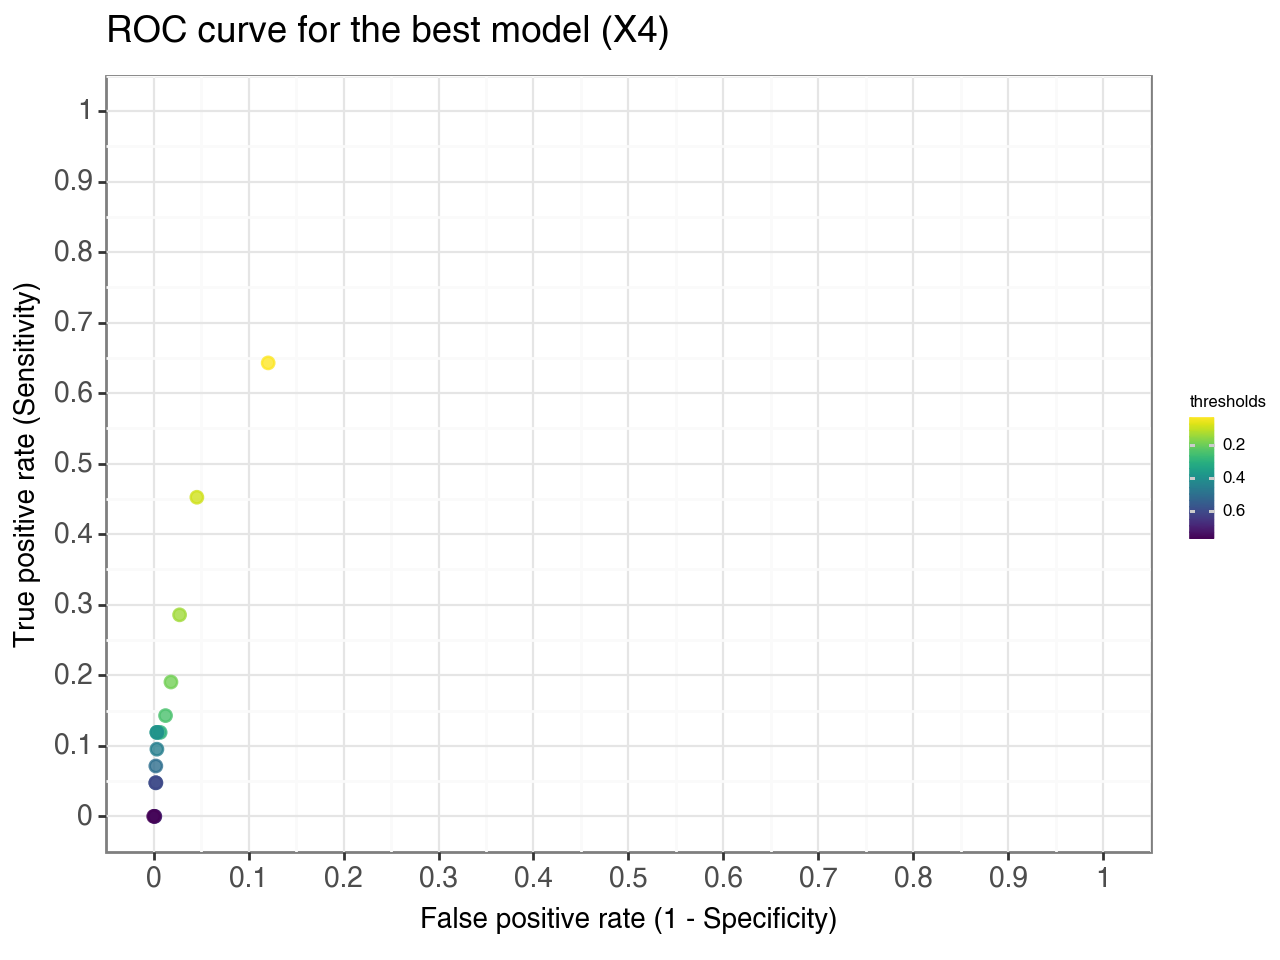

<Figure Size: (640 x 480)>

In [307]:
ggplot(tpr_fpr_for_thresholds, aes(x = 'false_positive_rates', y = 'true_positive_rates', color='thresholds'))\
        + labs(
            x = "False positive rate (1 - Specificity)", 
            y = "True positive rate (Sensitivity)",
            title = 'ROC curve for the best model (X4)'
        )\
        + geom_point(size=2, alpha=0.8) + scale_color_continuous(trans = 'reverse')\
        + scale_x_continuous(limits=(0,1), breaks = seq(0, 1.01, by = 0.1))\
        + scale_y_continuous(limits=(0,1), breaks = seq(0, 1.01, by = 0.1))\
        + theme_bw()\
        +theme(legend_position="right",
            axis_text=element_text(size=10),
            axis_title=element_text(size=10),
            legend_text = element_text(size = 6),
            legend_title = element_text(size = 6),
            legend_key_size=6)

In [308]:
%matplotlib inline

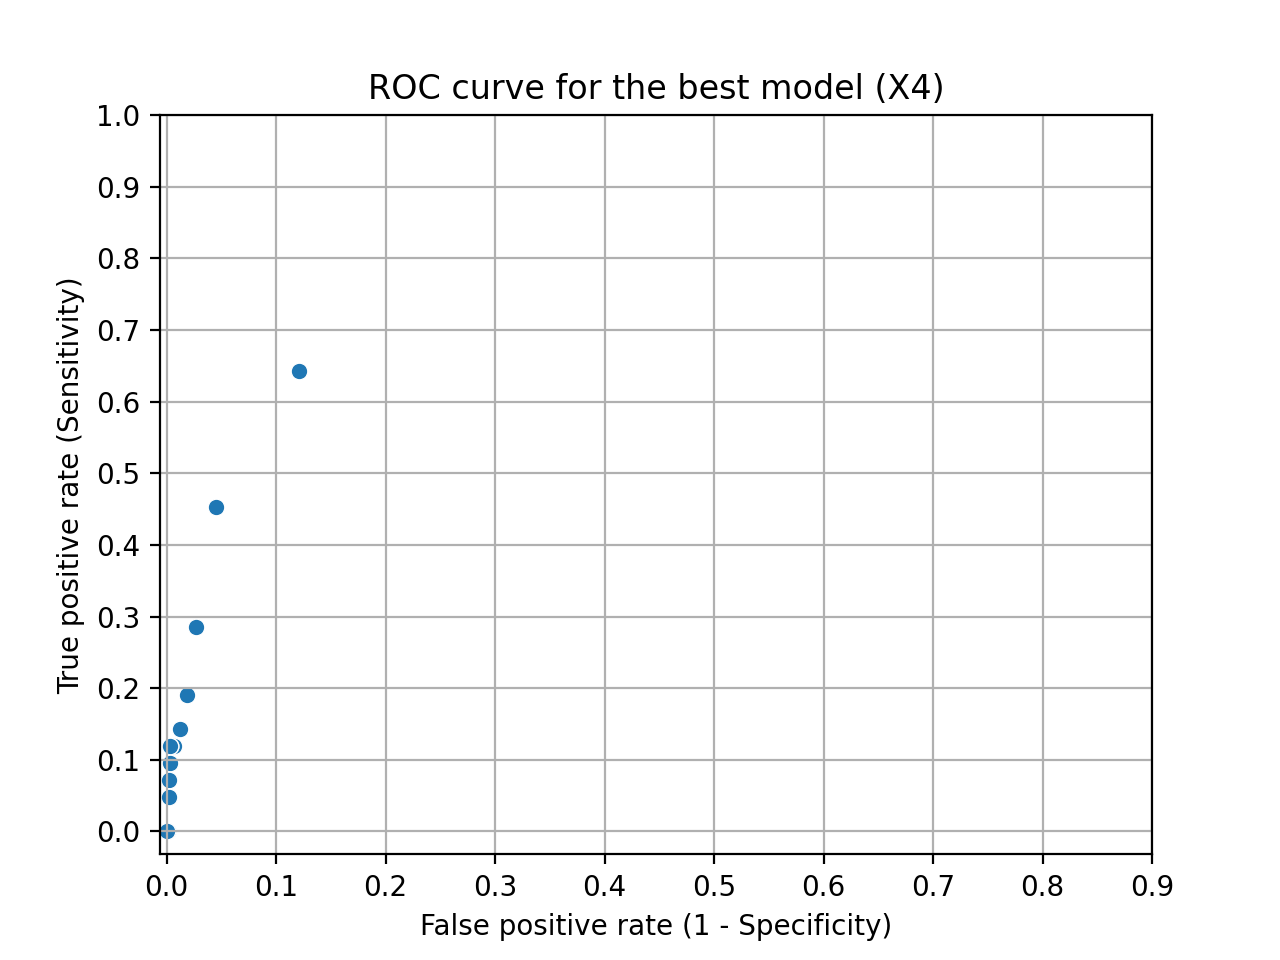

In [309]:
ax = sns.scatterplot(
    data = tpr_fpr_for_thresholds,
    x = 'false_positive_rates', 
    y = 'true_positive_rates', 
    marker = 'o')
ax.set_title('ROC curve for the best model (X4)')
ax.set_xlabel("False positive rate (1 - Specificity)"), 
ax.set_ylabel("True positive rate (Sensitivity)")
ax.set_xticks([x/10 for x in range(0,10,1)])
ax.set_yticks([x/10 for x in range(0,11,1)])
ax.grid(True);

**continuous ROC on holdout with best model (Logit 4)**

*ggplot*

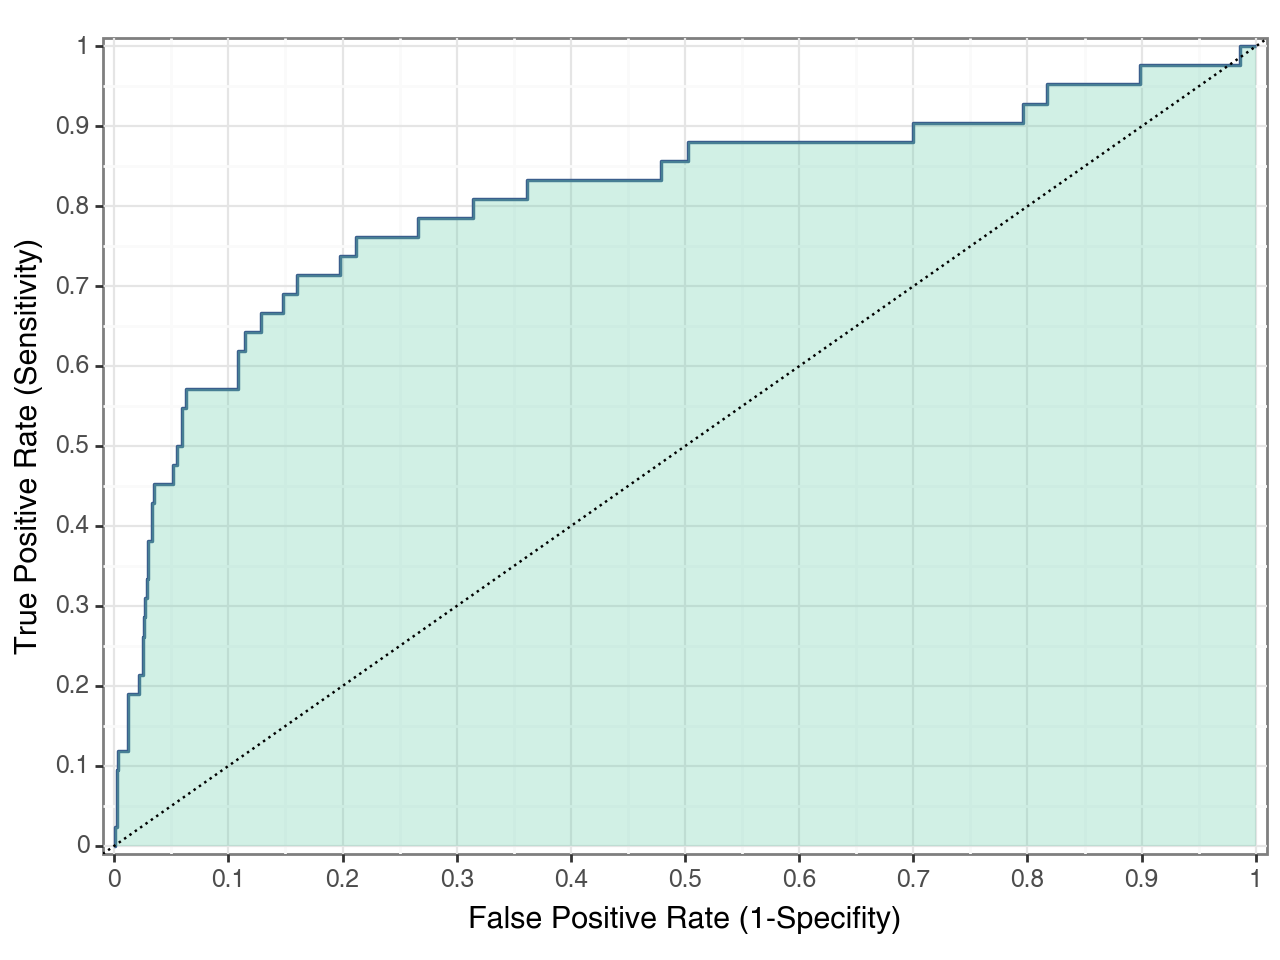

<Figure Size: (640 x 480)>

In [310]:
create_roc_plot(y_holdout, logit_predicted_probabilities_holdout)

**Confusion table with different tresholds**

default: the threshold 0.5 is used to convert probabilities to binary classes

In [311]:
logit_class_prediction = best_model.predict(best_model_X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0],' (no default): ',counts[0])
print(values[1],' (default): ',counts[1])

0  (no default):  916
1  (default):  5


confusion matrix: summarize different type of errors and successfully predicted cases   
positive = "yes": explicitly specify the positive case

In [312]:
cm_object1 = confusion_matrix(y_holdout, logit_class_prediction, labels=[0,1])
cm1 = pd.DataFrame(cm_object1, 
    index=['Actual no default', 'Actual default'], 
    columns=['Predicted no default', 'Predicted default'])
cm1

,Predicted no default,Predicted default
Actual no default,877,2
Actual default,39,3


Applying different thresholds

- 0.5 same as before

In [313]:
holdout_prediction = np.where(logit_predicted_probabilities_holdout < 0.5, 0, 1)
cm_object1b = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
cm1b = pd.DataFrame(cm_object1b, 
    index=['Actual no default', 'Actual default'], 
    columns=['Predicted no default', 'Predicted default'])
cm1b

,Predicted no default,Predicted default
Actual no default,877,2
Actual default,39,3


In [314]:
print(f'FPR: {round(cm1b.iloc[0,1] / cm1b.iloc[0].sum(), 3)}')

FPR: 0.002


In [315]:
mean_predicted_default_prob = np.mean(logit_predicted_probabilities_holdout)
round(mean_predicted_default_prob, 3)

0.035

In [316]:
holdout_prediction = np.where(logit_predicted_probabilities_holdout < mean_predicted_default_prob, 0, 1)
cm_object2 = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
cm2 = pd.DataFrame(cm_object2, 
    index=['Actul no defaul', 'Actual default'], 
    columns=['Predicted no default', 'Predicted default'])
cm2

,Predicted no default,Predicted default
Actul no defaul,708,171
Actual default,12,30


In [317]:
print(f'FPR: {round(cm2.iloc[0,1] / cm2.iloc[0].sum(), 3)}')

FPR: 0.195


#### Calibration curve

How well do estimated vs actual event probabilities relate to each other?

In [318]:
# holdout.reset_index(drop = True, inplace = True)

In [319]:
holdout = pd.concat([best_model_X_holdout, y_holdout], axis=1)
holdout["best_logit_no_loss_pred"] = logit_predicted_probabilities_holdout
create_calibration_plot(
    holdout, 
    # file_name = "ch17-figure-1-logit-m4-calibration",
    prob_var='best_logit_no_loss_pred', 
    actual_var='default',
    y_lab="Actual event probability", 
    n_bins=10, 
    breaks=None)

ValueError: Length of values (921) does not match length of index (1842)